### Import libs

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

### Import Data

In [2]:
electric_gen_df = pd.read_csv('https://catalog.eppo.go.th/dataset/cc2df961-bc3c-42bd-a423-14d533932c6c/resource/738041df-8e3d-4548-891f-3becece157d2/download/dataset_11_31.csv')

In [3]:
power_gen_df = pd.read_csv('https://catalog.eppo.go.th/dataset/bfdfabd4-b67f-4aee-b0e9-cfbb418a59c0/resource/edd5d4f8-f32e-4366-8573-52ba242c6bd1/download/dataset_11_27.csv')

In [4]:
emission_df = pd.read_csv('https://catalog.eppo.go.th/dataset/512aa812-f4f6-4481-9f9e-c3fe30643b63/resource/e95b7777-058b-4099-a1f3-e6d5ef60a732/download/dataset_11_62.csv')

### Cleaning Data

Dataset: การใช้เชื้อเพลิงในการผลิตไฟฟ้าของ กฟผ.

In [5]:
electric_gen_df.head()

Year     Month    Fuel Ttpe  Quantity   UNIT
0  1986   January  NATURAL GAS   8125.86  MMSCF
1  1986  February  NATURAL GAS   6895.85  MMSCF
2  1986     March  NATURAL GAS   8260.35  MMSCF
3  1986     April  NATURAL GAS   7423.69  MMSCF
4  1986       May  NATURAL GAS   8244.17  MMSCF

In [6]:
electric_gen_df.rename(columns={'Fuel Ttpe': 'Fuel Type'}, inplace=True)

In [7]:
electric_gen_df.head()

Year     Month    Fuel Type  Quantity   UNIT
0  1986   January  NATURAL GAS   8125.86  MMSCF
1  1986  February  NATURAL GAS   6895.85  MMSCF
2  1986     March  NATURAL GAS   8260.35  MMSCF
3  1986     April  NATURAL GAS   7423.69  MMSCF
4  1986       May  NATURAL GAS   8244.17  MMSCF

In [8]:
electric_gen_df['Fuel Type'].unique()

array(['NATURAL GAS', 'LIGNITE', 'DIESEL OIL', 'FUEL OIL', 'PALM OIL'],
      dtype=object)

In [9]:
electric_gen_df.isna().sum()

Year         0
Month        0
Fuel Type    0
Quantity     0
UNIT         0
dtype: int64

In [10]:
pivot_electric_gen_df = electric_gen_df.pivot_table(
    index=['Year', 'Month'], 
    columns='Fuel Type', 
    values='Quantity',
    fill_value = 0  # Fill missing values with 0
)

# Reset index to make 'Year' and 'Month' regular columns
pivot_electric_gen_df.reset_index(inplace=True)

# Drop the unnecessary 'Fuel Type' level in the columns and rename
pivot_electric_gen_df.columns.name = None  # Remove the 'Fuel Type' name from the columns

pivot_electric_gen_df

Year     Month  DIESEL OIL   FUEL OIL   LIGNITE  NATURAL GAS  PALM OIL
0    1986     April    0.537000  86.436000   273.687     7423.690         0
1    1986    August    0.434000  66.373000   428.256     7370.100         0
2    1986  December    0.374000  68.509000   518.620     8784.050         0
3    1986  February    1.056000  77.013000   278.687     6895.850         0
4    1986   January    0.520000  54.575000   438.482     8125.860         0
..    ...       ...         ...        ...       ...          ...       ...
458  2024   January    0.413018   0.000000  1022.443    33512.763         0
459  2024      July    6.400631   0.000000  1029.043    28848.165         0
460  2024      June    0.886987   0.000000  1053.415    30058.858         0
461  2024     March    1.031234   0.000000  1086.090    36909.817         0
462  2024       May    1.131571   2.939805  1105.556    35149.500         0

[463 rows x 7 columns]

In [11]:
# Month Order
month_order = [
    'January', 'February', 'March', 'April', 'May', 'June', 
    'July', 'August', 'September', 'October', 'November', 'December'
]

# Ensure 'Month' column is a categorical type with the correct order
pivot_electric_gen_df['Month'] = pd.Categorical(pivot_electric_gen_df['Month'], categories=month_order, ordered=True)

# Sort by 'Year' and 'Month'
pivot_electric_gen_df.sort_values(by=['Year', 'Month'], inplace=True)

pivot_electric_gen_df


Year     Month  DIESEL OIL   FUEL OIL   LIGNITE  NATURAL GAS  PALM OIL
4    1986   January    0.520000  54.575000   438.482     8125.860         0
3    1986  February    1.056000  77.013000   278.687     6895.850         0
7    1986     March    2.446000  61.806000   268.723     8260.350         0
0    1986     April    0.537000  86.436000   273.687     7423.690         0
8    1986       May    0.552000  79.655000   323.138     8244.170         0
..    ...       ...         ...        ...       ...          ...       ...
461  2024     March    1.031234   0.000000  1086.090    36909.817         0
456  2024     April    0.719586   0.000000  1044.680    33653.353         0
462  2024       May    1.131571   2.939805  1105.556    35149.500         0
460  2024      June    0.886987   0.000000  1053.415    30058.858         0
459  2024      July    6.400631   0.000000  1029.043    28848.165         0

[463 rows x 7 columns]

In [12]:
pivot_electric_gen_df.rename(columns={
    'DIESEL OIL': 'Disel_Oil_m.litres',
    'FUEL OIL': 'Fuel_Oil_m.litres',
    'LIGNITE': 'Lignite_1k_ton',
    'NATURAL GAS': 'Natural_Gas_mmscf',
    'PALM OIL': 'Palm_Oil_m.litres'}, inplace=True)

In [13]:
pivot_electric_gen_df

Year     Month  Disel_Oil_m.litres  Fuel_Oil_m.litres  Lignite_1k_ton  \
4    1986   January            0.520000          54.575000         438.482   
3    1986  February            1.056000          77.013000         278.687   
7    1986     March            2.446000          61.806000         268.723   
0    1986     April            0.537000          86.436000         273.687   
8    1986       May            0.552000          79.655000         323.138   
..    ...       ...                 ...                ...             ...   
461  2024     March            1.031234           0.000000        1086.090   
456  2024     April            0.719586           0.000000        1044.680   
462  2024       May            1.131571           2.939805        1105.556   
460  2024      June            0.886987           0.000000        1053.415   
459  2024      July            6.400631           0.000000        1029.043   

     Natural_Gas_mmscf  Palm_Oil_m.litres  
4             8125.860                  0  
3             6895.850                  0  
7             8260.350                  0  
0             7423.690                  0  
8             8244.170                  0  
..                 ...                ...  
461          36909.817                  0  
456          33653.353                  0  
462          35149.500                  0  
460          30058.858                  0  
459          28848.165                  0  

[463 rows x 7 columns]

Dataset: การผลิตไฟฟ้าแยกตามชนิดเชื้อเพลิง

In [14]:
power_gen_df.head()

Year     MONTH          Fuel Type  Quantity UNIT
0  1986   January  Hydro Electricity    218.90  GWh
1  1986  February  Hydro Electricity    391.76  GWh
2  1986     March  Hydro Electricity    629.74  GWh
3  1986     April  Hydro Electricity    633.91  GWh
4  1986       May  Hydro Electricity    498.05  GWh

In [15]:
power_gen_df.rename(columns={'MONTH': 'Month'}, inplace=True)

In [16]:
power_gen_df

Year     Month          Fuel Type    Quantity UNIT
0     1986   January  Hydro Electricity  218.900000  GWh
1     1986  February  Hydro Electricity  391.760000  GWh
2     1986     March  Hydro Electricity  629.740000  GWh
3     1986     April  Hydro Electricity  633.910000  GWh
4     1986       May  Hydro Electricity  498.050000  GWh
...    ...       ...                ...         ...  ...
3215  2024      July     Coal & Lignite   12.954298  GWh
3216  2024      July        Natural Gas   55.139539  GWh
3217  2024      July             Diesel    0.168388  GWh
3218  2024      July           Imported   19.582340  GWh
3219  2024      July   Renewable Energy   10.040885  GWh

[3220 rows x 5 columns]

In [17]:
power_gen_df.isna().sum()

Year         0
Month        0
Fuel Type    0
Quantity     0
UNIT         0
dtype: int64

In [18]:
pivot_power_gen_df = power_gen_df.pivot_table(
    index=['Year', 'Month'], 
    columns='Fuel Type', 
    values='Quantity',
    fill_value = 0  # Fill missing values with 0
)

# Reset index to make 'Year' and 'Month' regular columns
pivot_power_gen_df.reset_index(inplace=True)

# Drop the unnecessary 'Fuel Type' level in the columns and rename
pivot_power_gen_df.columns.name = None  # Remove the 'Fuel Type' name from the columns

pivot_power_gen_df

Year     Month  Coal & Lignite    Diesel  Fuel Oil  Hydro Electricity  \
0    1986     April      336.140000  0.490000    333.95         633.910000   
1    1986    August      517.400000  0.380000    246.90         542.000000   
2    1986  December      589.380000  0.090000    265.77         229.090000   
3    1986  February      323.550000  2.050000    288.67         391.760000   
4    1986   January      512.630000  0.190000    229.46         218.900000   
..    ...       ...             ...       ...       ...                ...   
458  2024   January     2596.178616  1.497000      0.00         649.653000   
459  2024      July       12.954298  0.168388      0.00           2.114554   
460  2024      June     2478.963325  3.476000      0.00         485.647000   
461  2024     March     3056.239817  3.805000      0.00         648.986000   
462  2024       May     3012.505365  4.492000     10.78         646.737000   

       Imported   Natural Gas  Renewable Energy  
0      33.79000    817.250000          0.000000  
1      91.24000    800.960000          0.000000  
2      43.00000    966.210000          0.000000  
3      52.14000    755.350000          0.000000  
4      57.00000    880.340000          0.000000  
..          ...           ...               ...  
458  2143.29200  10801.564440       2058.437464  
459    19.58234     55.139539         10.040885  
460  2853.09100  12301.857730       1956.249964  
461  2687.75100  12990.405050       2041.311809  
462  2691.00700  13563.087020       1928.082576  

[463 rows x 9 columns]

In [19]:
# Month Order
month_order = [
    'January', 'February', 'March', 'April', 'May', 'June', 
    'July', 'August', 'September', 'October', 'November', 'December'
]

# Ensure 'Month' column is a categorical type with the correct order
pivot_power_gen_df['Month'] = pd.Categorical(pivot_power_gen_df['Month'], categories=month_order, ordered=True)

# Sort by 'Year' and 'Month'
pivot_power_gen_df.sort_values(by=['Year', 'Month'], inplace=True)

pivot_power_gen_df

Year     Month  Coal & Lignite    Diesel  Fuel Oil  Hydro Electricity  \
4    1986   January      512.630000  0.190000    229.46         218.900000   
3    1986  February      323.550000  2.050000    288.67         391.760000   
7    1986     March      331.950000  4.970000    227.37         629.740000   
0    1986     April      336.140000  0.490000    333.95         633.910000   
8    1986       May      404.260000  0.640000    302.11         498.050000   
..    ...       ...             ...       ...       ...                ...   
461  2024     March     3056.239817  3.805000      0.00         648.986000   
456  2024     April     2949.052335  2.586000      0.00         672.547000   
462  2024       May     3012.505365  4.492000     10.78         646.737000   
460  2024      June     2478.963325  3.476000      0.00         485.647000   
459  2024      July       12.954298  0.168388      0.00           2.114554   

       Imported   Natural Gas  Renewable Energy  
4      57.00000    880.340000          0.000000  
3      52.14000    755.350000          0.000000  
7      41.86000    899.540000          0.000000  
0      33.79000    817.250000          0.000000  
8      47.28000    900.010000          0.000000  
..          ...           ...               ...  
461  2687.75100  12990.405050       2041.311809  
456  2854.62900  13252.440610       2077.745447  
462  2691.00700  13563.087020       1928.082576  
460  2853.09100  12301.857730       1956.249964  
459    19.58234     55.139539         10.040885  

[463 rows x 9 columns]

In [20]:
pivot_power_gen_df.rename(columns={
    'Coal & Lignite': 'Coal_Lignite_GWh',
    'Diesel': 'Diesel_GWh',
    'Fuel Oil': 'Fuel_Oil_GWh',
    'Hydro Electricity': 'Hydro_Elec_GWh',
    'Imported': 'Imported_GWh',
    'Natural Gas': 'Natural_Gas_GWh',
    'Renewable Energy': 'Renewable_GWh'}, inplace=True)

In [21]:
pivot_power_gen_df

Year     Month  Coal_Lignite_GWh  Diesel_GWh  Fuel_Oil_GWh  \
4    1986   January        512.630000    0.190000        229.46   
3    1986  February        323.550000    2.050000        288.67   
7    1986     March        331.950000    4.970000        227.37   
0    1986     April        336.140000    0.490000        333.95   
8    1986       May        404.260000    0.640000        302.11   
..    ...       ...               ...         ...           ...   
461  2024     March       3056.239817    3.805000          0.00   
456  2024     April       2949.052335    2.586000          0.00   
462  2024       May       3012.505365    4.492000         10.78   
460  2024      June       2478.963325    3.476000          0.00   
459  2024      July         12.954298    0.168388          0.00   

     Hydro_Elec_GWh  Imported_GWh  Natural_Gas_GWh  Renewable_GWh  
4        218.900000      57.00000       880.340000       0.000000  
3        391.760000      52.14000       755.350000       0.000000  
7        629.740000      41.86000       899.540000       0.000000  
0        633.910000      33.79000       817.250000       0.000000  
8        498.050000      47.28000       900.010000       0.000000  
..              ...           ...              ...            ...  
461      648.986000    2687.75100     12990.405050    2041.311809  
456      672.547000    2854.62900     13252.440610    2077.745447  
462      646.737000    2691.00700     13563.087020    1928.082576  
460      485.647000    2853.09100     12301.857730    1956.249964  
459        2.114554      19.58234        55.139539      10.040885  

[463 rows x 9 columns]

Dataset: การปล่อย CO2 แยกตามชนิดเชื้อเพลิงในการผลิตไฟฟ้า

In [22]:
emission_df.head()

Year     Month Fuel Type  Quantity        UNIT
0  1987   January       Oil    179.68  1,000 Tons
1  1987  February       Oil    133.53  1,000 Tons
2  1987     March       Oil    145.80  1,000 Tons
3  1987     April       Oil    143.35  1,000 Tons
4  1987       May       Oil    168.65  1,000 Tons

In [23]:
emission_df.isna().sum()

Year         0
Month        0
Fuel Type    0
Quantity     0
UNIT         0
dtype: int64

In [24]:
pivot_emission_df = emission_df.pivot_table(
    index=['Year', 'Month'], 
    columns='Fuel Type', 
    values='Quantity',
    fill_value = 0  # Fill missing values with 0
)

# Reset index to make 'Year' and 'Month' regular columns
pivot_emission_df.reset_index(inplace=True)

# Drop the unnecessary 'Fuel Type' level in the columns and rename
pivot_emission_df.columns.name = None  # Remove the 'Fuel Type' name from the columns

pivot_emission_df

Year     Month  Coal/Lignite  Natural Gas     Oil
0    1987     April        554.95       586.91  143.35
1    1987    August        547.41       706.81  143.80
2    1987  December        454.12       680.61  156.22
3    1987  February        417.09       516.39  133.53
4    1987   January        513.29       510.66  179.68
..    ...       ...           ...          ...     ...
446  2024   January       2604.13      4535.03   66.03
447  2024      July       2479.34      4560.14   38.54
448  2024      June       2598.68      5133.65   37.23
449  2024     March       3041.34      5352.50   42.22
450  2024       May       2913.34      5598.33   40.74

[451 rows x 5 columns]

In [25]:
# Month Order
month_order = [
    'January', 'February', 'March', 'April', 'May', 'June', 
    'July', 'August', 'September', 'October', 'November', 'December'
]

# Ensure 'Month' column is a categorical type with the correct order
pivot_emission_df['Month'] = pd.Categorical(pivot_emission_df['Month'], categories=month_order, ordered=True)

# Sort by 'Year' and 'Month'
pivot_emission_df.sort_values(by=['Year', 'Month'], inplace=True)

pivot_emission_df

Year     Month  Coal/Lignite  Natural Gas     Oil
4    1987   January        513.29       510.66  179.68
3    1987  February        417.09       516.39  133.53
7    1987     March        543.47       597.48  145.80
0    1987     April        554.95       586.91  143.35
8    1987       May       1096.98       669.35  168.65
..    ...       ...           ...          ...     ...
449  2024     March       3041.34      5352.50   42.22
444  2024     April       2969.23      5380.83   39.60
450  2024       May       2913.34      5598.33   40.74
448  2024      June       2598.68      5133.65   37.23
447  2024      July       2479.34      4560.14   38.54

[451 rows x 5 columns]

In [26]:
pivot_emission_df.rename(columns={
    'Coal/Lignite': 'Coal_Lignite_1k_tons',
    'Natural Gas': 'Natural_Gas_1k_tons',
    'Oil': 'Oil_1k_tons'}, inplace=True)

In [27]:
pivot_emission_df

Year     Month  Coal_Lignite_1k_tons  Natural_Gas_1k_tons  Oil_1k_tons
4    1987   January                513.29               510.66       179.68
3    1987  February                417.09               516.39       133.53
7    1987     March                543.47               597.48       145.80
0    1987     April                554.95               586.91       143.35
8    1987       May               1096.98               669.35       168.65
..    ...       ...                   ...                  ...          ...
449  2024     March               3041.34              5352.50        42.22
444  2024     April               2969.23              5380.83        39.60
450  2024       May               2913.34              5598.33        40.74
448  2024      June               2598.68              5133.65        37.23
447  2024      July               2479.34              4560.14        38.54

[451 rows x 5 columns]

In [28]:
pivot_emission_df['Total_Emission_1k_tons'] = (pivot_emission_df['Coal_Lignite_1k_tons'] +
                                                pivot_emission_df['Natural_Gas_1k_tons'] +
                                                pivot_emission_df['Oil_1k_tons'])

pivot_emission_df

Year     Month  Coal_Lignite_1k_tons  Natural_Gas_1k_tons  Oil_1k_tons  \
4    1987   January                513.29               510.66       179.68   
3    1987  February                417.09               516.39       133.53   
7    1987     March                543.47               597.48       145.80   
0    1987     April                554.95               586.91       143.35   
8    1987       May               1096.98               669.35       168.65   
..    ...       ...                   ...                  ...          ...   
449  2024     March               3041.34              5352.50        42.22   
444  2024     April               2969.23              5380.83        39.60   
450  2024       May               2913.34              5598.33        40.74   
448  2024      June               2598.68              5133.65        37.23   
447  2024      July               2479.34              4560.14        38.54   

     Total_Emission_1k_tons  
4                   1203.63  
3                   1067.01  
7                   1286.75  
0                   1285.21  
8                   1934.98  
..                      ...  
449                 8436.06  
444                 8389.66  
450                 8552.41  
448                 7769.56  
447                 7078.02  

[451 rows x 6 columns]

Merging 3 datasets

In [29]:
merged_df = pd.merge(pivot_electric_gen_df, pivot_power_gen_df, on=['Year', 'Month'], how='outer')
merged_df = pd.merge(merged_df, pivot_emission_df, on=['Year', 'Month'], how='outer')

merged_df

Year     Month  Disel_Oil_m.litres  Fuel_Oil_m.litres  Lignite_1k_ton  \
0    1986   January            0.520000          54.575000         438.482   
1    1986  February            1.056000          77.013000         278.687   
2    1986     March            2.446000          61.806000         268.723   
3    1986     April            0.537000          86.436000         273.687   
4    1986       May            0.552000          79.655000         323.138   
..    ...       ...                 ...                ...             ...   
458  2024     March            1.031234           0.000000        1086.090   
459  2024     April            0.719586           0.000000        1044.680   
460  2024       May            1.131571           2.939805        1105.556   
461  2024      June            0.886987           0.000000        1053.415   
462  2024      July            6.400631           0.000000        1029.043   

     Natural_Gas_mmscf  Palm_Oil_m.litres  Coal_Lignite_GWh  Diesel_GWh  \
0             8125.860                  0        512.630000    0.190000   
1             6895.850                  0        323.550000    2.050000   
2             8260.350                  0        331.950000    4.970000   
3             7423.690                  0        336.140000    0.490000   
4             8244.170                  0        404.260000    0.640000   
..                 ...                ...               ...         ...   
458          36909.817                  0       3056.239817    3.805000   
459          33653.353                  0       2949.052335    2.586000   
460          35149.500                  0       3012.505365    4.492000   
461          30058.858                  0       2478.963325    3.476000   
462          28848.165                  0         12.954298    0.168388   

     Fuel_Oil_GWh  Hydro_Elec_GWh  Imported_GWh  Natural_Gas_GWh  \
0          229.46      218.900000      57.00000       880.340000   
1          288.67      391.760000      52.14000       755.350000   
2          227.37      629.740000      41.86000       899.540000   
3          333.95      633.910000      33.79000       817.250000   
4          302.11      498.050000      47.28000       900.010000   
..            ...             ...           ...              ...   
458          0.00      648.986000    2687.75100     12990.405050   
459          0.00      672.547000    2854.62900     13252.440610   
460         10.78      646.737000    2691.00700     13563.087020   
461          0.00      485.647000    2853.09100     12301.857730   
462          0.00        2.114554      19.58234        55.139539   

     Renewable_GWh  Coal_Lignite_1k_tons  Natural_Gas_1k_tons  Oil_1k_tons  \
0         0.000000                   NaN                  NaN          NaN   
1         0.000000                   NaN                  NaN          NaN   
2         0.000000                   NaN                  NaN          NaN   
3         0.000000                   NaN                  NaN          NaN   
4         0.000000                   NaN                  NaN          NaN   
..             ...                   ...                  ...          ...   
458    2041.311809               3041.34              5352.50        42.22   
459    2077.745447               2969.23              5380.83        39.60   
460    1928.082576               2913.34              5598.33        40.74   
461    1956.249964               2598.68              5133.65        37.23   
462      10.040885               2479.34              4560.14        38.54   

     Total_Emission_1k_tons  
0                       NaN  
1                       NaN  
2                       NaN  
3                       NaN  
4                       NaN  
..                      ...  
458                 8436.06  
459                 8389.66  
460                 8552.41  
461                 7769.56  
462                 7078.02  

[463 rows x 18 columns]

In [30]:
merged_df.isna().sum()

Year                       0
Month                      0
Disel_Oil_m.litres         0
Fuel_Oil_m.litres          0
Lignite_1k_ton             0
Natural_Gas_mmscf          0
Palm_Oil_m.litres          0
Coal_Lignite_GWh           0
Diesel_GWh                 0
Fuel_Oil_GWh               0
Hydro_Elec_GWh             0
Imported_GWh               0
Natural_Gas_GWh            0
Renewable_GWh              0
Coal_Lignite_1k_tons      12
Natural_Gas_1k_tons       12
Oil_1k_tons               12
Total_Emission_1k_tons    12
dtype: int64

In [31]:
merged_df.fillna(0, inplace=True)

In [32]:
merged_df.isna().sum()

Year                      0
Month                     0
Disel_Oil_m.litres        0
Fuel_Oil_m.litres         0
Lignite_1k_ton            0
Natural_Gas_mmscf         0
Palm_Oil_m.litres         0
Coal_Lignite_GWh          0
Diesel_GWh                0
Fuel_Oil_GWh              0
Hydro_Elec_GWh            0
Imported_GWh              0
Natural_Gas_GWh           0
Renewable_GWh             0
Coal_Lignite_1k_tons      0
Natural_Gas_1k_tons       0
Oil_1k_tons               0
Total_Emission_1k_tons    0
dtype: int64

In [33]:
merged_df

Year     Month  Disel_Oil_m.litres  Fuel_Oil_m.litres  Lignite_1k_ton  \
0    1986   January            0.520000          54.575000         438.482   
1    1986  February            1.056000          77.013000         278.687   
2    1986     March            2.446000          61.806000         268.723   
3    1986     April            0.537000          86.436000         273.687   
4    1986       May            0.552000          79.655000         323.138   
..    ...       ...                 ...                ...             ...   
458  2024     March            1.031234           0.000000        1086.090   
459  2024     April            0.719586           0.000000        1044.680   
460  2024       May            1.131571           2.939805        1105.556   
461  2024      June            0.886987           0.000000        1053.415   
462  2024      July            6.400631           0.000000        1029.043   

     Natural_Gas_mmscf  Palm_Oil_m.litres  Coal_Lignite_GWh  Diesel_GWh  \
0             8125.860                  0        512.630000    0.190000   
1             6895.850                  0        323.550000    2.050000   
2             8260.350                  0        331.950000    4.970000   
3             7423.690                  0        336.140000    0.490000   
4             8244.170                  0        404.260000    0.640000   
..                 ...                ...               ...         ...   
458          36909.817                  0       3056.239817    3.805000   
459          33653.353                  0       2949.052335    2.586000   
460          35149.500                  0       3012.505365    4.492000   
461          30058.858                  0       2478.963325    3.476000   
462          28848.165                  0         12.954298    0.168388   

     Fuel_Oil_GWh  Hydro_Elec_GWh  Imported_GWh  Natural_Gas_GWh  \
0          229.46      218.900000      57.00000       880.340000   
1          288.67      391.760000      52.14000       755.350000   
2          227.37      629.740000      41.86000       899.540000   
3          333.95      633.910000      33.79000       817.250000   
4          302.11      498.050000      47.28000       900.010000   
..            ...             ...           ...              ...   
458          0.00      648.986000    2687.75100     12990.405050   
459          0.00      672.547000    2854.62900     13252.440610   
460         10.78      646.737000    2691.00700     13563.087020   
461          0.00      485.647000    2853.09100     12301.857730   
462          0.00        2.114554      19.58234        55.139539   

     Renewable_GWh  Coal_Lignite_1k_tons  Natural_Gas_1k_tons  Oil_1k_tons  \
0         0.000000                  0.00                 0.00         0.00   
1         0.000000                  0.00                 0.00         0.00   
2         0.000000                  0.00                 0.00         0.00   
3         0.000000                  0.00                 0.00         0.00   
4         0.000000                  0.00                 0.00         0.00   
..             ...                   ...                  ...          ...   
458    2041.311809               3041.34              5352.50        42.22   
459    2077.745447               2969.23              5380.83        39.60   
460    1928.082576               2913.34              5598.33        40.74   
461    1956.249964               2598.68              5133.65        37.23   
462      10.040885               2479.34              4560.14        38.54   

     Total_Emission_1k_tons  
0                      0.00  
1                      0.00  
2                      0.00  
3                      0.00  
4                      0.00  
..                      ...  
458                 8436.06  
459                 8389.66  
460                 8552.41  
461                 7769.56  
462                 7078.02  

[463 rows x 18 columns]

### EDA

In [34]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 463 entries, 0 to 462
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   Year                    463 non-null    int64   
 1   Month                   463 non-null    category
 2   Disel_Oil_m.litres      463 non-null    float64 
 3   Fuel_Oil_m.litres       463 non-null    float64 
 4   Lignite_1k_ton          463 non-null    float64 
 5   Natural_Gas_mmscf       463 non-null    float64 
 6   Palm_Oil_m.litres       463 non-null    int64   
 7   Coal_Lignite_GWh        463 non-null    float64 
 8   Diesel_GWh              463 non-null    float64 
 9   Fuel_Oil_GWh            463 non-null    float64 
 10  Hydro_Elec_GWh          463 non-null    float64 
 11  Imported_GWh            463 non-null    float64 
 12  Natural_Gas_GWh         463 non-null    float64 
 13  Renewable_GWh           463 non-null    float64 
 14  Coal_Lignite_1k_tons    46

In [35]:
#Change type of year and month to datetime. Set 'Date' as the index of the DataFrame

# Convert 'Month' column to string explicitly (in case it's a category type)
merged_df['Month'] = merged_df['Month'].astype(str)

# Combine 'Year' and 'Month' into a single 'Date' column (convert to datetime)
merged_df['Date'] = pd.to_datetime(merged_df['Year'].astype(str) + '-' + merged_df['Month'], format='%Y-%B')

# Set 'Date' as the index of the DataFrame
merged_df.set_index('Date', inplace=True)

In [36]:
merged_df.head()

Year     Month  Disel_Oil_m.litres  Fuel_Oil_m.litres  \
Date                                                                
1986-01-01  1986   January               0.520             54.575   
1986-02-01  1986  February               1.056             77.013   
1986-03-01  1986     March               2.446             61.806   
1986-04-01  1986     April               0.537             86.436   
1986-05-01  1986       May               0.552             79.655   

            Lignite_1k_ton  Natural_Gas_mmscf  Palm_Oil_m.litres  \
Date                                                               
1986-01-01         438.482            8125.86                  0   
1986-02-01         278.687            6895.85                  0   
1986-03-01         268.723            8260.35                  0   
1986-04-01         273.687            7423.69                  0   
1986-05-01         323.138            8244.17                  0   

            Coal_Lignite_GWh  Diesel_GWh  Fuel_Oil_GWh  Hydro_Elec_GWh  \
Date                                                                     
1986-01-01            512.63        0.19        229.46          218.90   
1986-02-01            323.55        2.05        288.67          391.76   
1986-03-01            331.95        4.97        227.37          629.74   
1986-04-01            336.14        0.49        333.95          633.91   
1986-05-01            404.26        0.64        302.11          498.05   

            Imported_GWh  Natural_Gas_GWh  Renewable_GWh  \
Date                                                       
1986-01-01         57.00           880.34            0.0   
1986-02-01         52.14           755.35            0.0   
1986-03-01         41.86           899.54            0.0   
1986-04-01         33.79           817.25            0.0   
1986-05-01         47.28           900.01            0.0   

            Coal_Lignite_1k_tons  Natural_Gas_1k_tons  Oil_1k_tons  \
Date                                                                 
1986-01-01                   0.0                  0.0          0.0   
1986-02-01                   0.0                  0.0          0.0   
1986-03-01                   0.0                  0.0          0.0   
1986-04-01                   0.0                  0.0          0.0   
1986-05-01                   0.0                  0.0          0.0   

            Total_Emission_1k_tons  
Date                                
1986-01-01                     0.0  
1986-02-01                     0.0  
1986-03-01                     0.0  
1986-04-01                     0.0  
1986-05-01                     0.0

C:\Users\Ekkar\AppData\Local\Temp\ipykernel_21732\3301863363.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(merged_df.corr(), annot = True, cmap = 'coolwarm')


<Axes: >

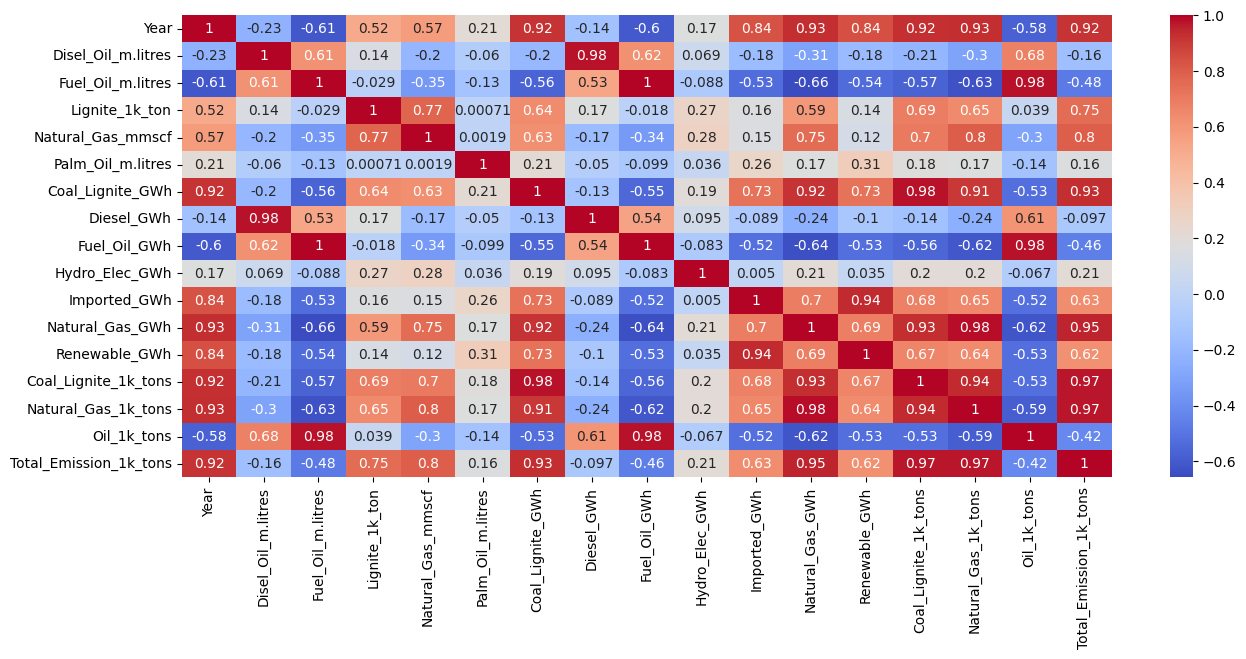

In [37]:
# Heat Map(Normal)
plt.figure(figsize=(15, 6))
sns.heatmap(merged_df.corr(), annot = True, cmap = 'coolwarm')

C:\Users\Ekkar\AppData\Local\Temp\ipykernel_21732\3917651770.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(merged_df.corr().abs(), annot = True, cmap = 'coolwarm')


<Axes: >

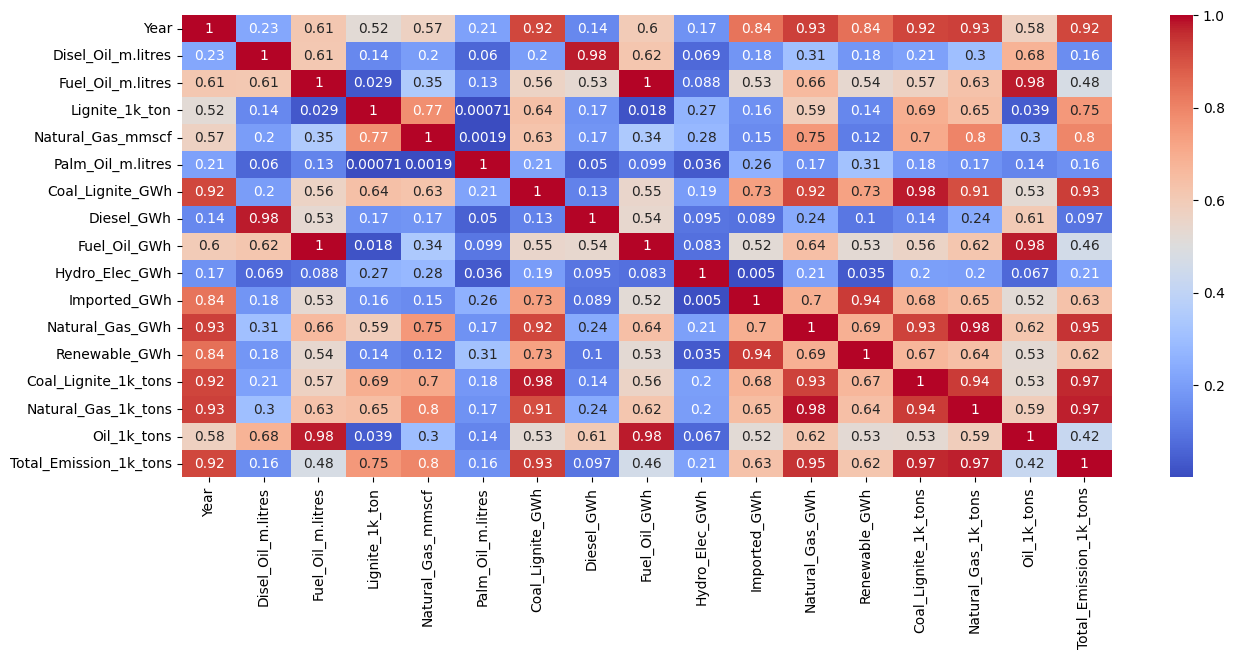

In [38]:
# Heat Map (Absolute)
plt.figure(figsize=(15, 6))
sns.heatmap(merged_df.corr().abs(), annot = True, cmap = 'coolwarm')

In [39]:
# Table Correlation
corr_matrix = merged_df.corr()

# Target variable
target_corr = corr_matrix['Total_Emission_1k_tons']

target_corr_sorted_desc = target_corr.sort_values(ascending=False)

print("Correlation with 'Total_Emission_1k_tons'")
print(target_corr_sorted_desc)

Correlation with 'Total_Emission_1k_tons'
Total_Emission_1k_tons    1.000000
Natural_Gas_1k_tons       0.972943
Coal_Lignite_1k_tons      0.967722
Natural_Gas_GWh           0.950646
Coal_Lignite_GWh          0.934534
Year                      0.918891
Natural_Gas_mmscf         0.796016
Lignite_1k_ton            0.752275
Imported_GWh              0.632450
Renewable_GWh             0.620237
Hydro_Elec_GWh            0.209096
Palm_Oil_m.litres         0.164002
Diesel_GWh               -0.097474
Disel_Oil_m.litres       -0.155389
Oil_1k_tons              -0.423017
Fuel_Oil_GWh             -0.461296
Fuel_Oil_m.litres        -0.476476
Name: Total_Emission_1k_tons, dtype: float64


C:\Users\Ekkar\AppData\Local\Temp\ipykernel_21732\610284142.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = merged_df.corr()


In [40]:
# Table Correlation (Absolute)
target_corr_abs_sorted_desc = target_corr.abs().sort_values(ascending=False)

print("Absolute Correlation with 'Total_Emission_1k_tons'")
print(target_corr_abs_sorted_desc)

Absolute Correlation with 'Total_Emission_1k_tons'
Total_Emission_1k_tons    1.000000
Natural_Gas_1k_tons       0.972943
Coal_Lignite_1k_tons      0.967722
Natural_Gas_GWh           0.950646
Coal_Lignite_GWh          0.934534
Year                      0.918891
Natural_Gas_mmscf         0.796016
Lignite_1k_ton            0.752275
Imported_GWh              0.632450
Renewable_GWh             0.620237
Fuel_Oil_m.litres         0.476476
Fuel_Oil_GWh              0.461296
Oil_1k_tons               0.423017
Hydro_Elec_GWh            0.209096
Palm_Oil_m.litres         0.164002
Disel_Oil_m.litres        0.155389
Diesel_GWh                0.097474
Name: Total_Emission_1k_tons, dtype: float64


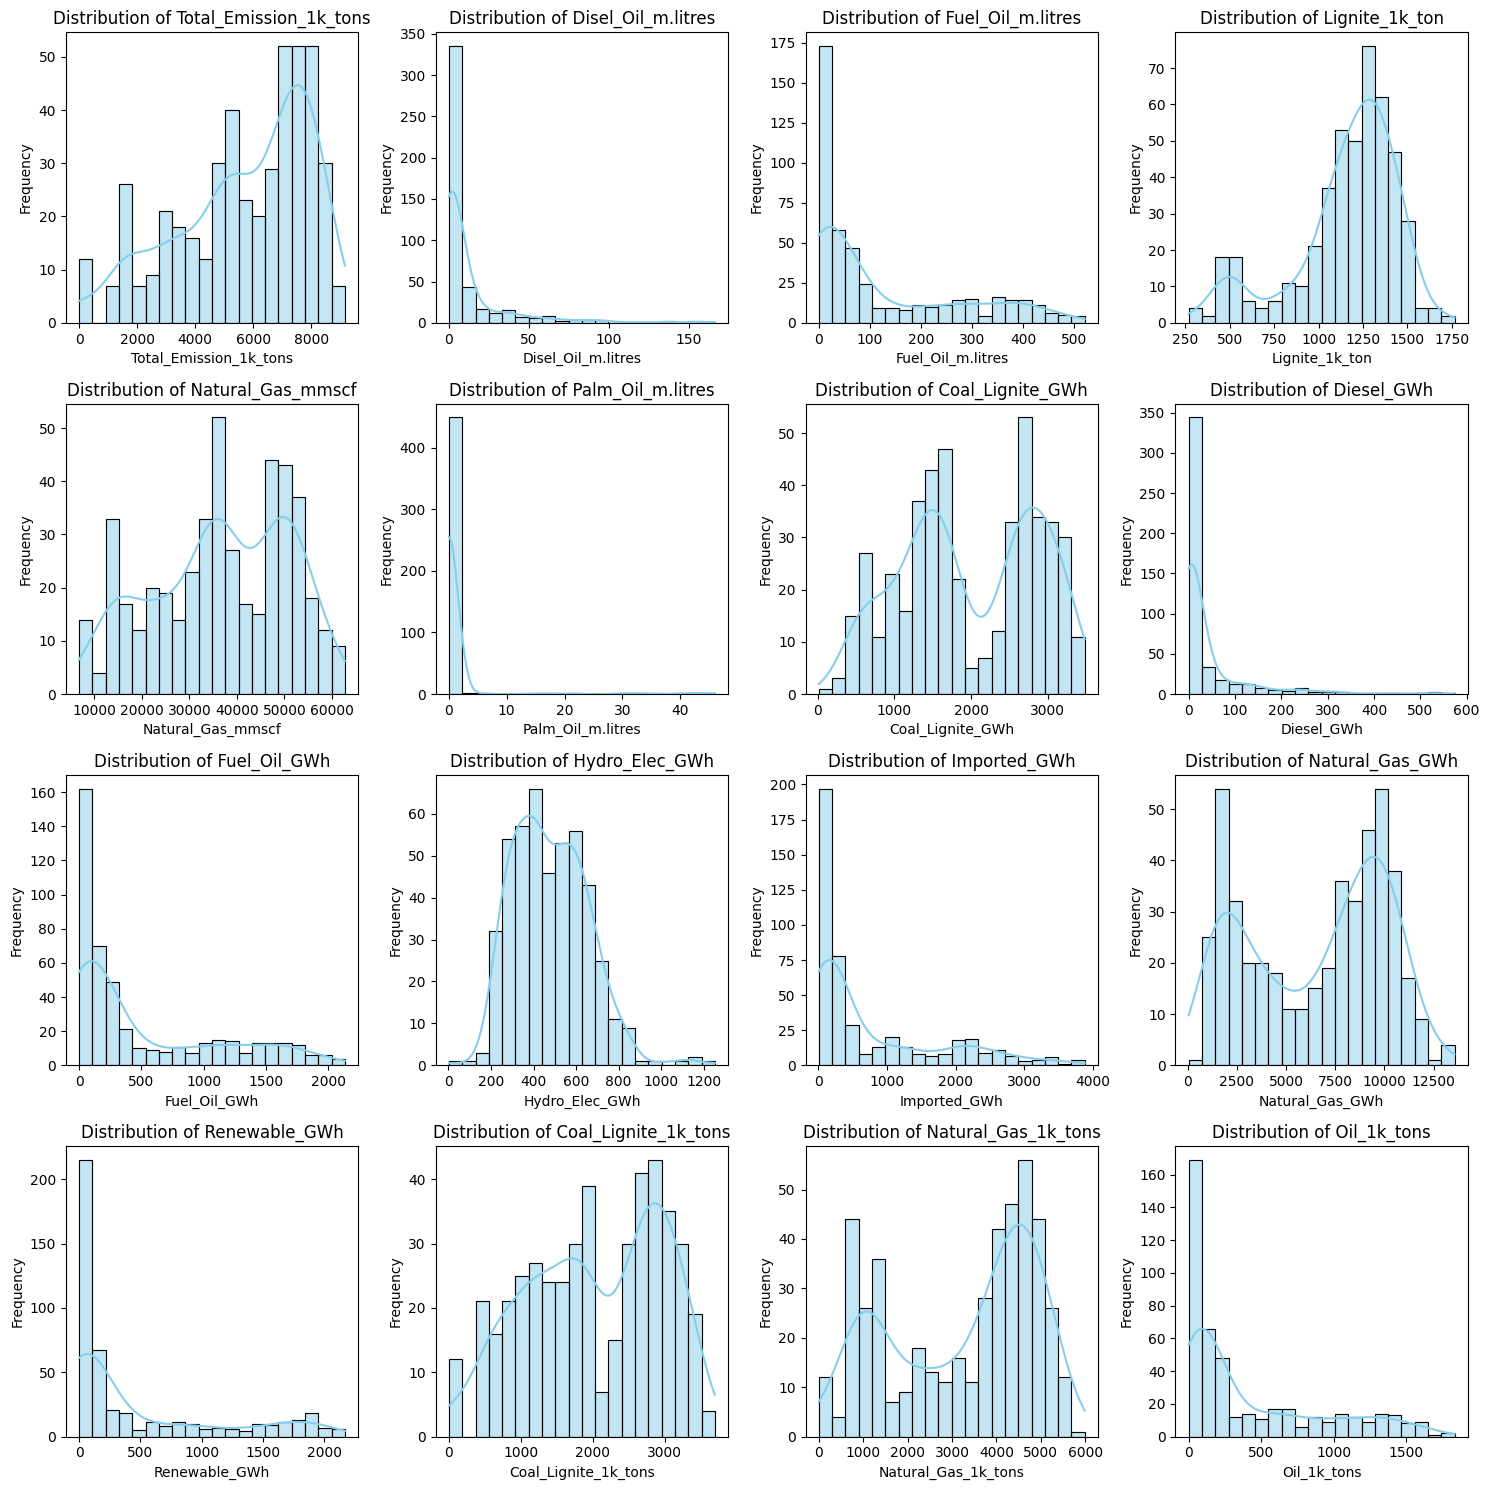

In [41]:
columns_to_plot = [
    'Total_Emission_1k_tons', 'Disel_Oil_m.litres', 'Fuel_Oil_m.litres', 'Lignite_1k_ton', 
    'Natural_Gas_mmscf', 'Palm_Oil_m.litres', 'Coal_Lignite_GWh', 'Diesel_GWh', 'Fuel_Oil_GWh', 
    'Hydro_Elec_GWh', 'Imported_GWh', 'Natural_Gas_GWh', 'Renewable_GWh', 
    'Coal_Lignite_1k_tons', 'Natural_Gas_1k_tons', 'Oil_1k_tons'
]

# Number of rows and columns
n_cols = 4
n_rows = 4

# Subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 15))

axes = axes.flatten()

for i, column in enumerate(columns_to_plot):
    sns.histplot(merged_df[column], kde=True, ax=axes[i], color='skyblue', bins=20)
    axes[i].set_title(f'Distribution of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

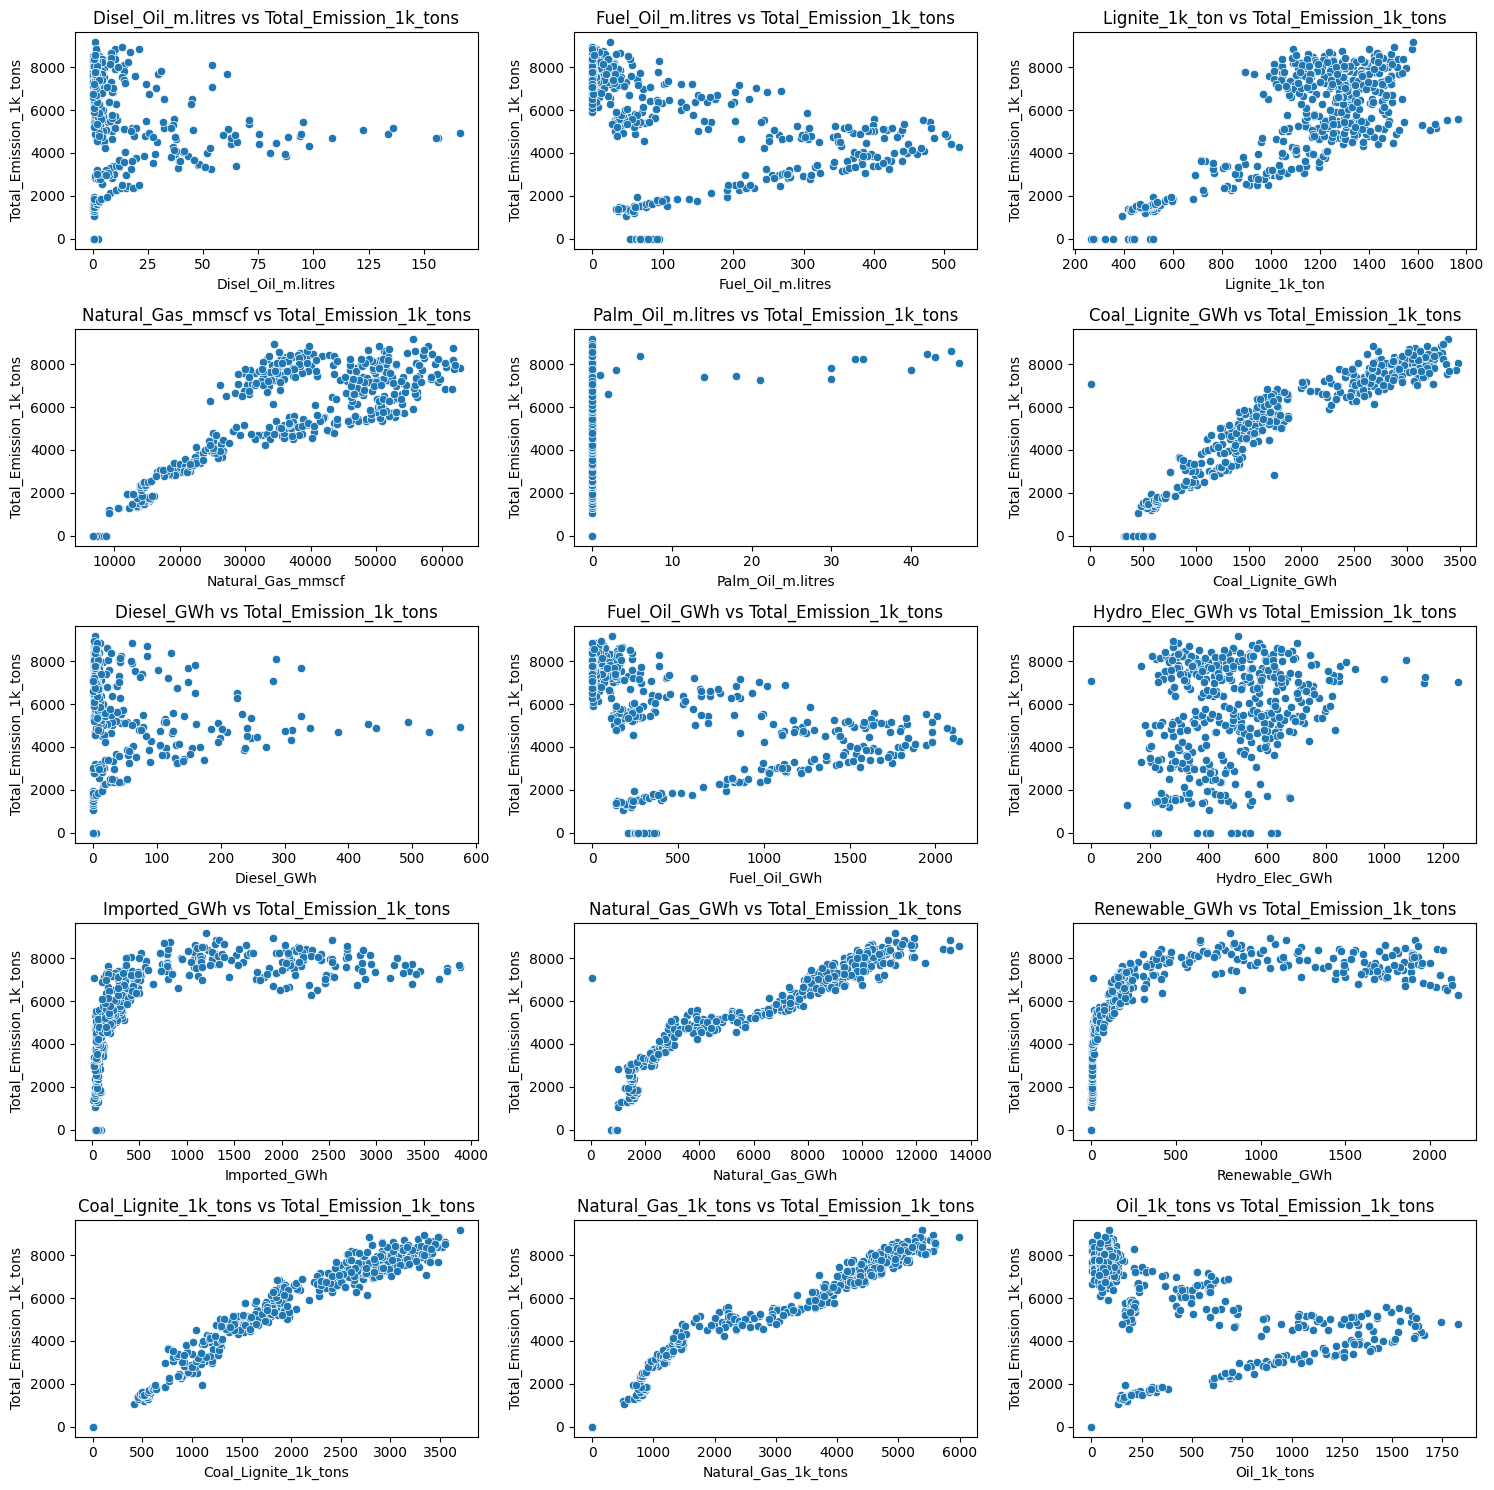

In [42]:
columns_to_plot = [
    'Disel_Oil_m.litres', 'Fuel_Oil_m.litres', 'Lignite_1k_ton', 
    'Natural_Gas_mmscf', 'Palm_Oil_m.litres', 'Coal_Lignite_GWh', 'Diesel_GWh', 'Fuel_Oil_GWh', 
    'Hydro_Elec_GWh', 'Imported_GWh', 'Natural_Gas_GWh', 'Renewable_GWh', 
    'Coal_Lignite_1k_tons', 'Natural_Gas_1k_tons', 'Oil_1k_tons'
]

# Number of rows and columns
n_cols = 3
n_rows = 5

# Subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 15))

axes = axes.flatten()

for i, column in enumerate(columns_to_plot):
    sns.scatterplot(x=merged_df[column], y=merged_df['Total_Emission_1k_tons'], ax=axes[i])
    axes[i].set_title(f'{column} vs Total_Emission_1k_tons')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Total_Emission_1k_tons')

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [43]:
df_scale = merged_df.copy()

In [44]:
#Scale power generation
df_scale['Coal_Lignite_GWh'] = merged_df['Coal_Lignite_GWh']/max(merged_df['Coal_Lignite_GWh'])
df_scale['Fuel_Oil_GWh'] = merged_df['Fuel_Oil_GWh']/max(merged_df['Fuel_Oil_GWh'])
df_scale['Hydro_Elec_GWh'] = merged_df['Hydro_Elec_GWh']/max(merged_df['Hydro_Elec_GWh'])
df_scale['Natural_Gas_GWh'] = merged_df['Natural_Gas_GWh']/max(merged_df['Natural_Gas_GWh'])
df_scale['Renewable_GWh'] = merged_df['Renewable_GWh']/max(merged_df['Renewable_GWh'])
df_scale['Imported_GWh'] = merged_df['Imported_GWh']/max(merged_df['Imported_GWh'])

#Scale CO2 emission of each fuel types
df_scale['Coal_Lignite_1k_tons'] = merged_df['Coal_Lignite_1k_tons']/max(merged_df['Coal_Lignite_1k_tons'])
df_scale['Natural_Gas_1k_tons'] = merged_df['Natural_Gas_1k_tons']/max(merged_df['Natural_Gas_1k_tons'])
df_scale['Oil_1k_tons'] = merged_df['Oil_1k_tons']/max(merged_df['Oil_1k_tons'])

#Scale fuel types
df_scale['Fuel_Oil_m.litres'] = merged_df['Fuel_Oil_m.litres']/max(merged_df['Fuel_Oil_m.litres'])
df_scale['Lignite_1k_ton'] = merged_df['Lignite_1k_ton']/max(merged_df['Lignite_1k_ton'])
df_scale['Natural_Gas_mmscf'] = merged_df['Natural_Gas_mmscf']/max(merged_df['Natural_Gas_mmscf'])

#Scale total CO2 emission
df_scale['Total_Emission_1k_tons'] = merged_df['Total_Emission_1k_tons']/max(merged_df['Total_Emission_1k_tons'])

In [45]:
df_scale.head()

Year     Month  Disel_Oil_m.litres  Fuel_Oil_m.litres  \
Date                                                                
1986-01-01  1986   January               0.520           0.104863   
1986-02-01  1986  February               1.056           0.147976   
1986-03-01  1986     March               2.446           0.118757   
1986-04-01  1986     April               0.537           0.166082   
1986-05-01  1986       May               0.552           0.153052   

            Lignite_1k_ton  Natural_Gas_mmscf  Palm_Oil_m.litres  \
Date                                                               
1986-01-01        0.248308           0.129545                  0   
1986-02-01        0.157817           0.109936                  0   
1986-03-01        0.152175           0.131689                  0   
1986-04-01        0.154986           0.118351                  0   
1986-05-01        0.182989           0.131431                  0   

            Coal_Lignite_GWh  Diesel_GWh  Fuel_Oil_GWh  Hydro_Elec_GWh  \
Date                                                                     
1986-01-01          0.147208        0.19      0.107419        0.174818   
1986-02-01          0.092911        2.05      0.135138        0.312868   
1986-03-01          0.095324        4.97      0.106441        0.502924   
1986-04-01          0.096527        0.49      0.156335        0.506254   
1986-05-01          0.116088        0.64      0.141429        0.397753   

            Imported_GWh  Natural_Gas_GWh  Renewable_GWh  \
Date                                                       
1986-01-01      0.014696         0.064907            0.0   
1986-02-01      0.013443         0.055692            0.0   
1986-03-01      0.010793         0.066323            0.0   
1986-04-01      0.008712         0.060255            0.0   
1986-05-01      0.012190         0.066357            0.0   

            Coal_Lignite_1k_tons  Natural_Gas_1k_tons  Oil_1k_tons  \
Date                                                                 
1986-01-01                   0.0                  0.0          0.0   
1986-02-01                   0.0                  0.0          0.0   
1986-03-01                   0.0                  0.0          0.0   
1986-04-01                   0.0                  0.0          0.0   
1986-05-01                   0.0                  0.0          0.0   

            Total_Emission_1k_tons  
Date                                
1986-01-01                     0.0  
1986-02-01                     0.0  
1986-03-01                     0.0  
1986-04-01                     0.0  
1986-05-01                     0.0

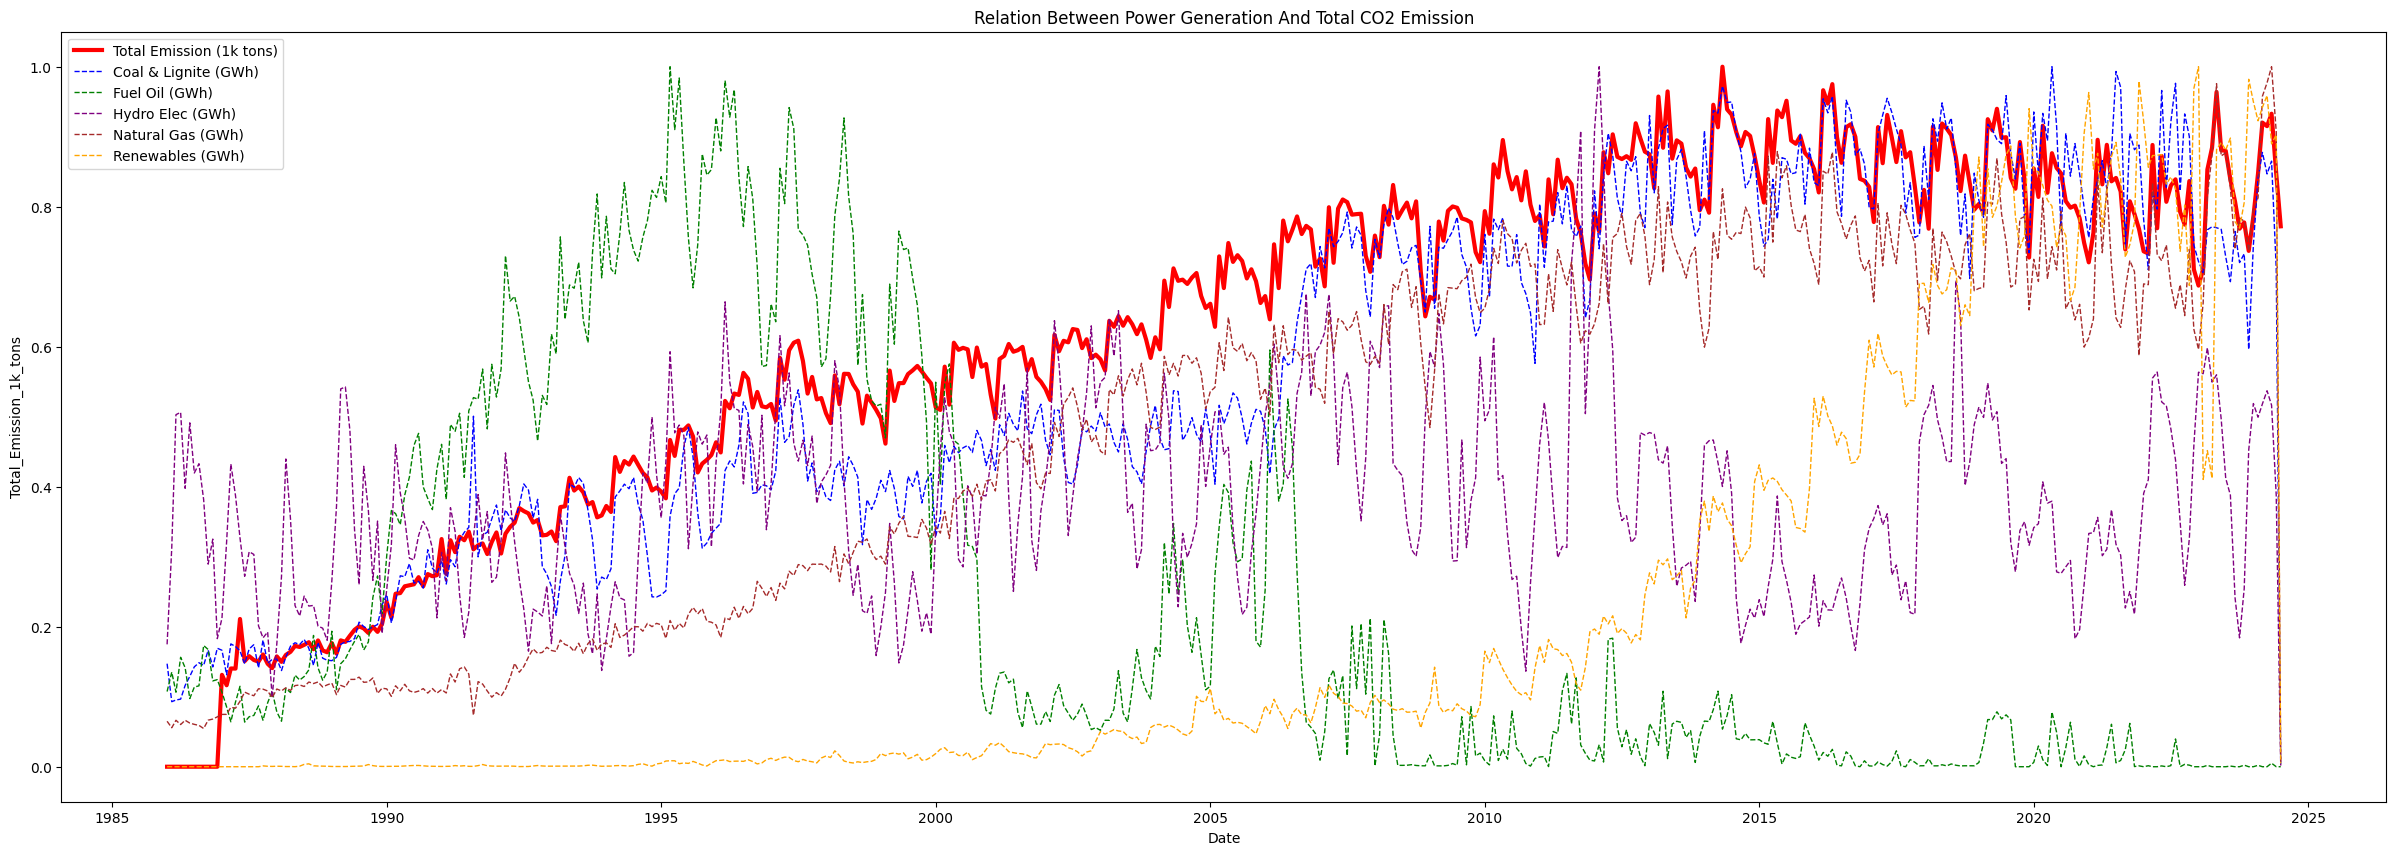

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 10))

sns.lineplot(data=df_scale['Total_Emission_1k_tons'], color='red', linewidth=3, linestyle='-', label='Total Emission (1k tons)')
sns.lineplot(data=df_scale['Coal_Lignite_GWh'], color='blue', linewidth=1, linestyle='--', label='Coal & Lignite (GWh)')
sns.lineplot(data=df_scale['Fuel_Oil_GWh'], color='green', linewidth=1, linestyle='--', label='Fuel Oil (GWh)')
sns.lineplot(data=df_scale['Hydro_Elec_GWh'], color='purple', linewidth=1, linestyle='--', label='Hydro Elec (GWh)')
sns.lineplot(data=df_scale['Natural_Gas_GWh'], color='brown', linewidth=1, linestyle='--', label='Natural Gas (GWh)')
sns.lineplot(data=df_scale['Renewable_GWh'], color='orange', linewidth=1, linestyle='--', label='Renewables (GWh)')
plt.title('Relation Between Power Generation And Total CO2 Emission')
plt.legend()
plt.show()

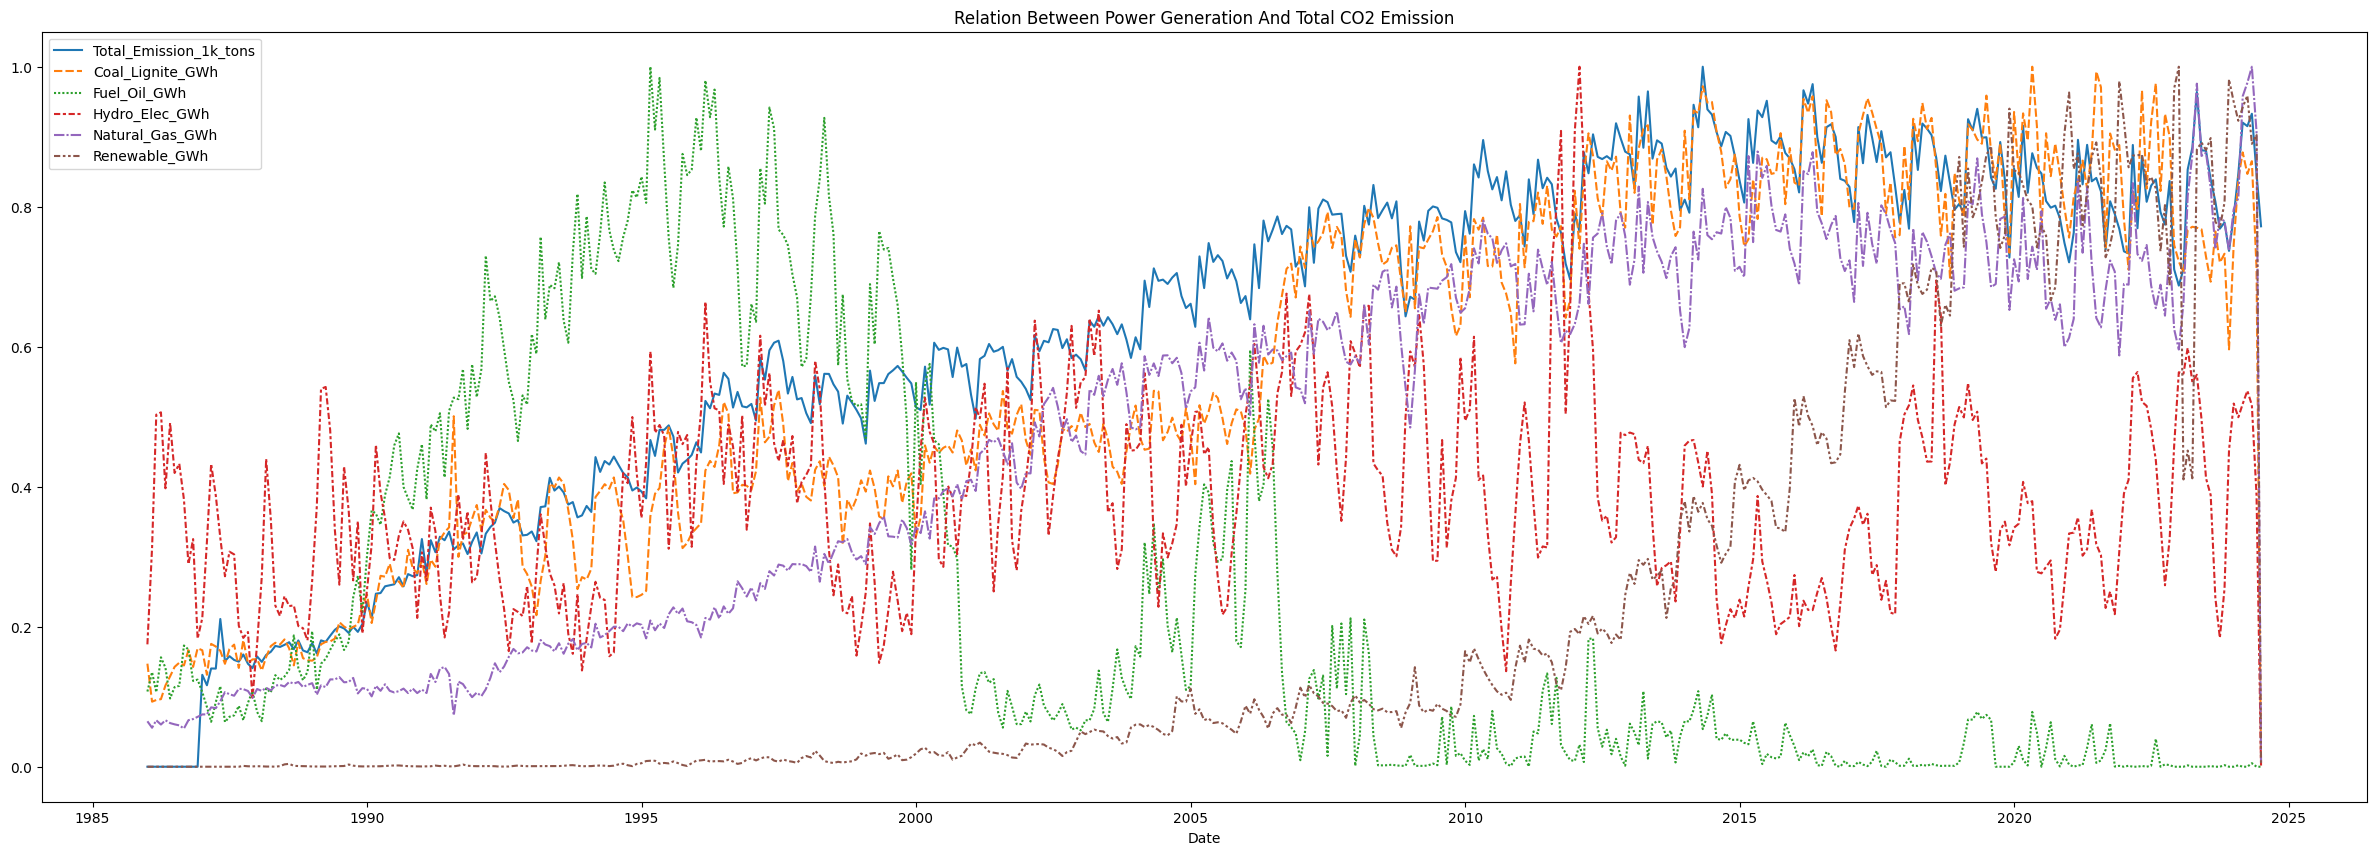

In [47]:

plt.figure(figsize=(30,10))
sns.lineplot(df_scale[['Total_Emission_1k_tons','Coal_Lignite_GWh','Fuel_Oil_GWh','Hydro_Elec_GWh','Natural_Gas_GWh', 'Renewable_GWh']])
plt.title('Relation Between Power Generation And Total CO2 Emission')
plt.show()

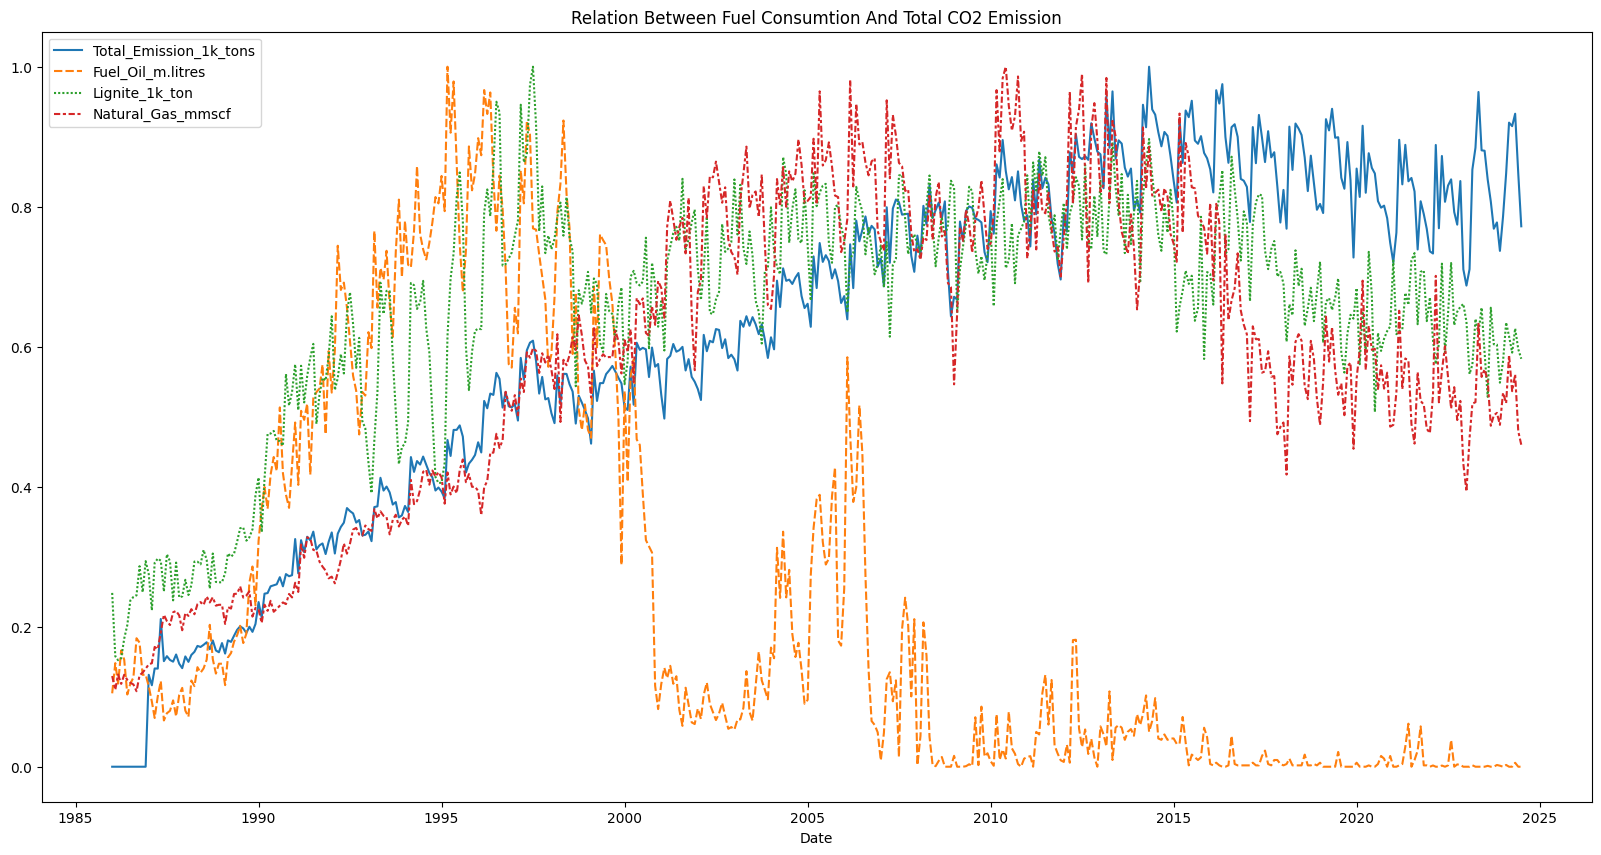

In [48]:

plt.figure(figsize=(20,10))
sns.lineplot(df_scale[['Total_Emission_1k_tons','Fuel_Oil_m.litres',	'Lignite_1k_ton',	'Natural_Gas_mmscf']])
plt.title('Relation Between Fuel Consumtion And Total CO2 Emission')
plt.show()

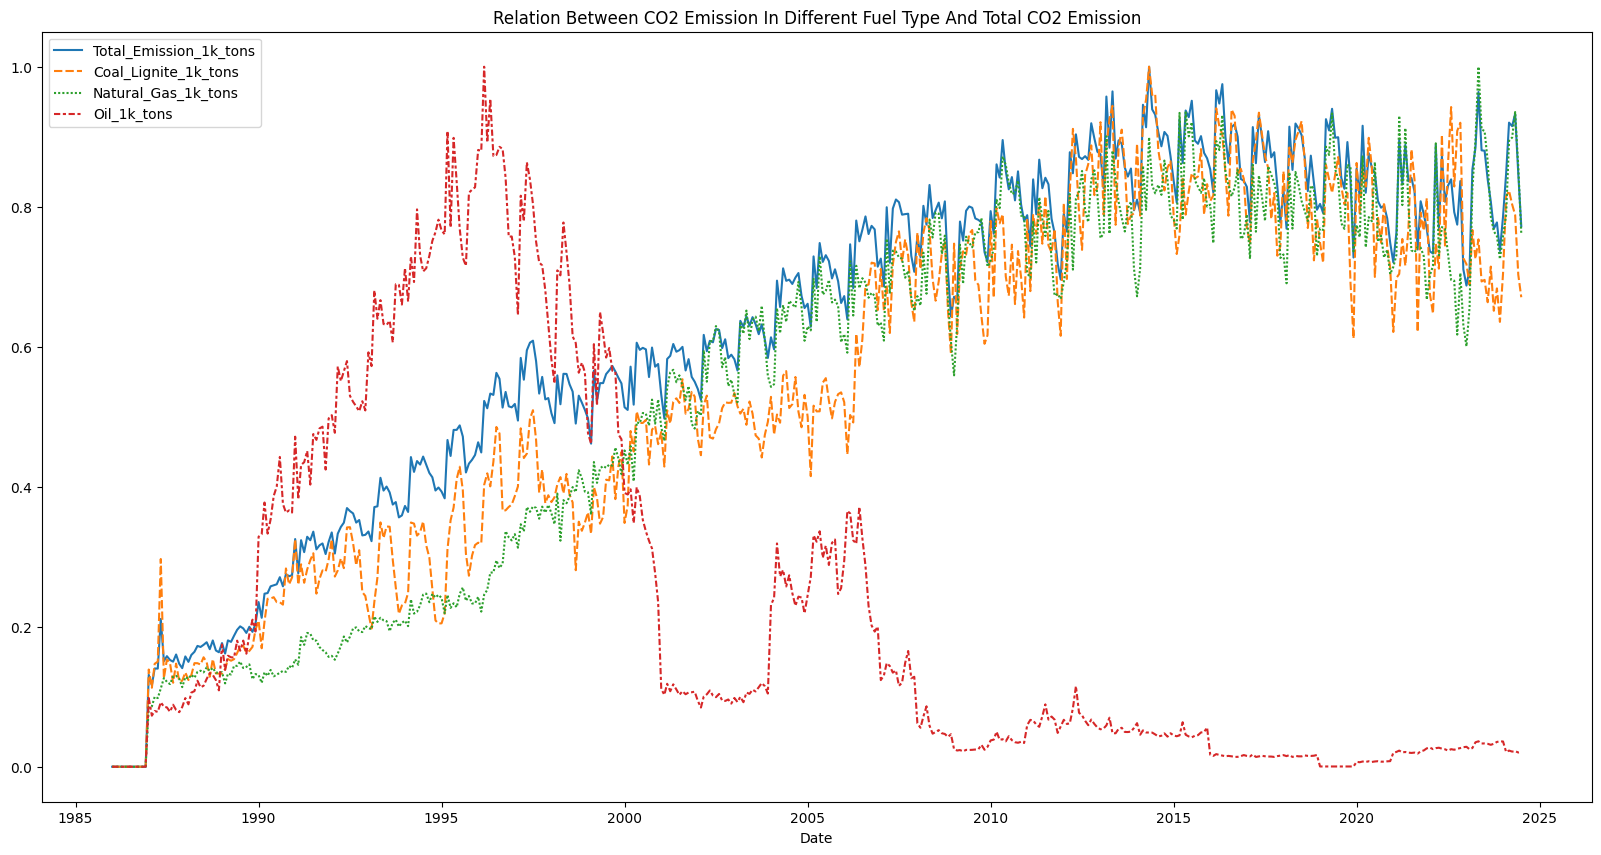

In [49]:

plt.figure(figsize=(20,10))
sns.lineplot(df_scale[['Total_Emission_1k_tons','Coal_Lignite_1k_tons',	'Natural_Gas_1k_tons',	'Oil_1k_tons']])
plt.title('Relation Between CO2 Emission In Different Fuel Type And Total CO2 Emission')
plt.show()

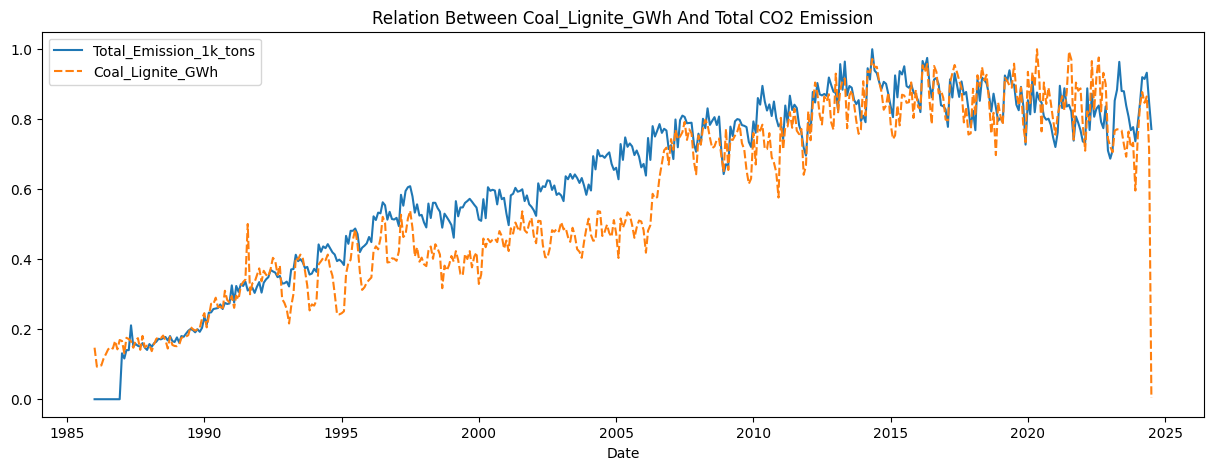

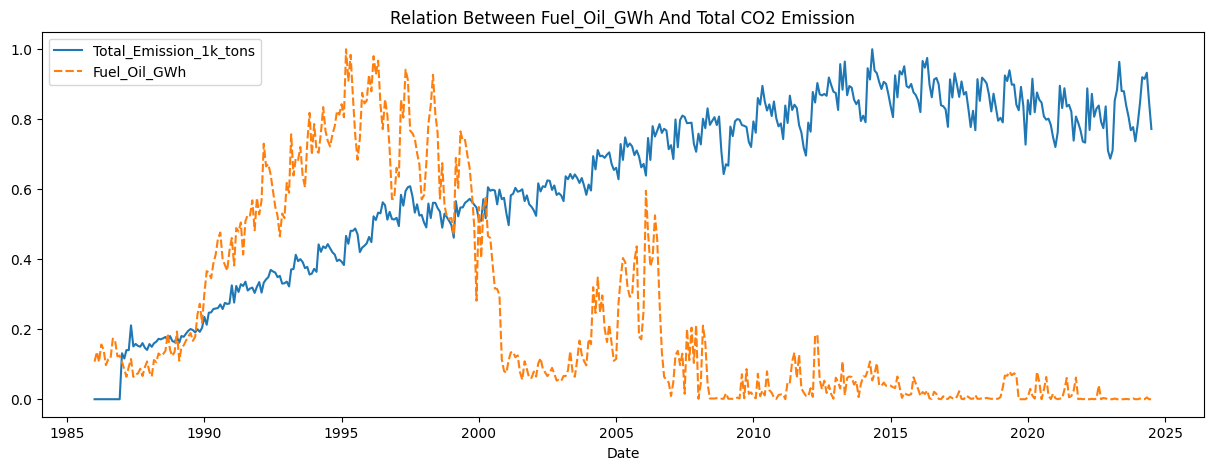

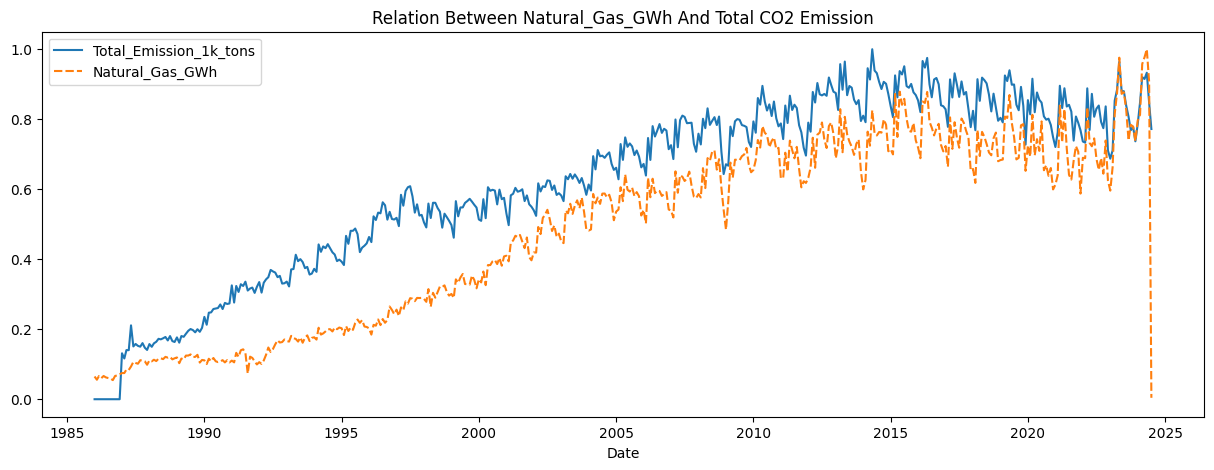

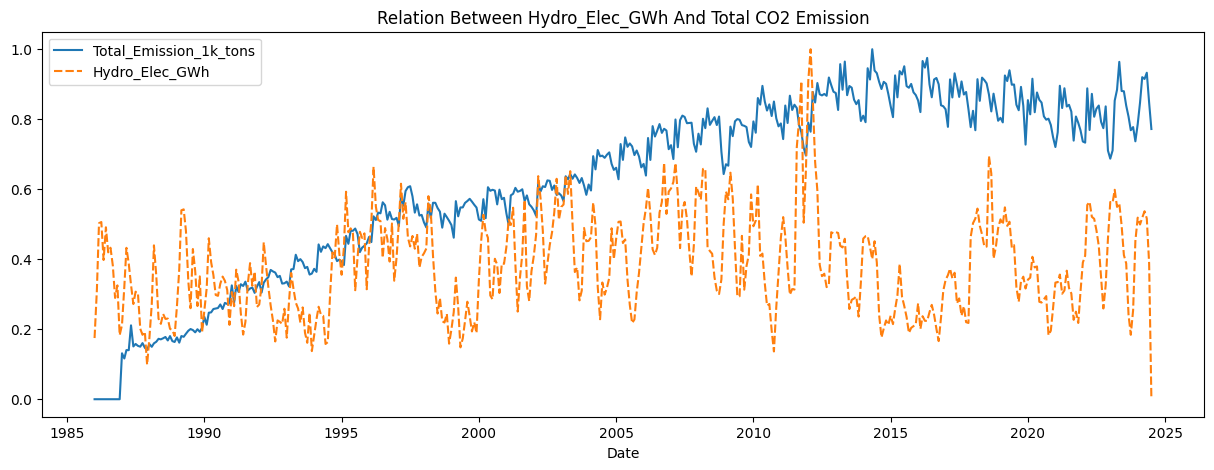

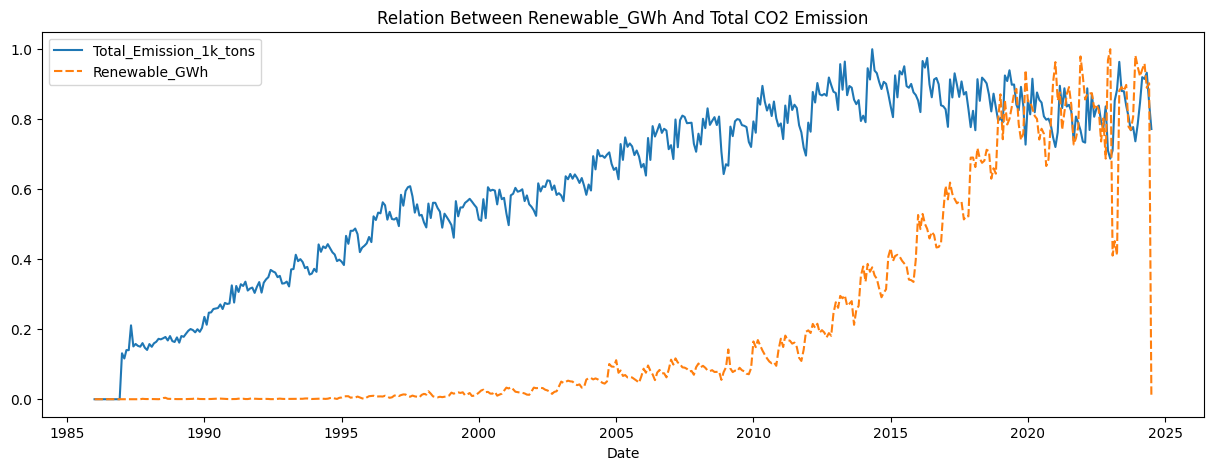

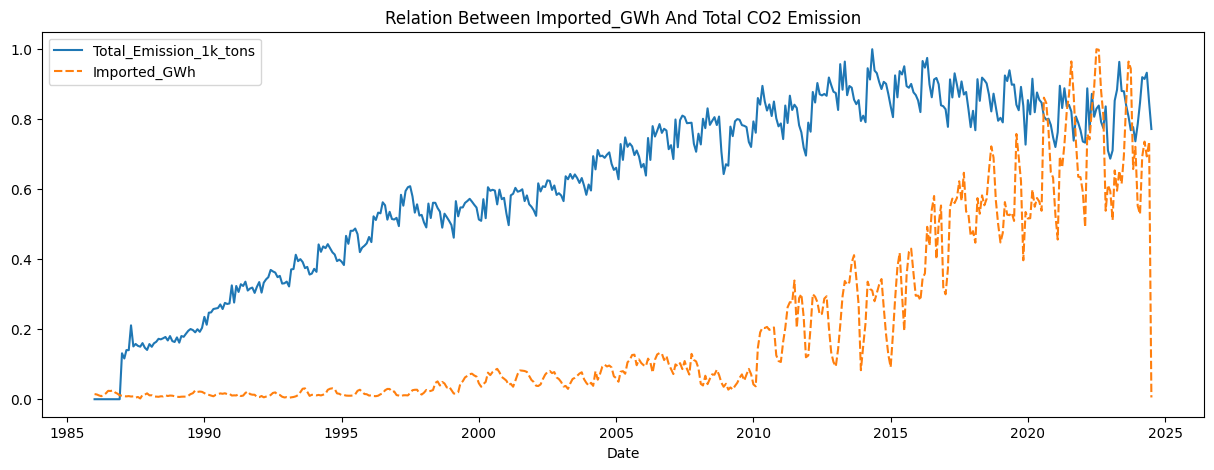

In [50]:

plt.figure(figsize=(15,5))
sns.lineplot(df_scale[['Total_Emission_1k_tons','Coal_Lignite_GWh']])
plt.title('Relation Between Coal_Lignite_GWh And Total CO2 Emission')
plt.show()

plt.figure(figsize=(15,5))
sns.lineplot(df_scale[['Total_Emission_1k_tons','Fuel_Oil_GWh']])
plt.title('Relation Between Fuel_Oil_GWh And Total CO2 Emission')
plt.show()

plt.figure(figsize=(15,5))
sns.lineplot(df_scale[['Total_Emission_1k_tons','Natural_Gas_GWh']])
plt.title('Relation Between Natural_Gas_GWh And Total CO2 Emission')
plt.show()

plt.figure(figsize=(15,5))
sns.lineplot(df_scale[['Total_Emission_1k_tons','Hydro_Elec_GWh']])
plt.title('Relation Between Hydro_Elec_GWh And Total CO2 Emission')
plt.show()

plt.figure(figsize=(15,5))
sns.lineplot(df_scale[['Total_Emission_1k_tons', 'Renewable_GWh']])
plt.title('Relation Between Renewable_GWh And Total CO2 Emission')
plt.show()

plt.figure(figsize=(15,5))
sns.lineplot(df_scale[['Total_Emission_1k_tons', 'Imported_GWh']])
plt.title('Relation Between Imported_GWh And Total CO2 Emission')
plt.show()

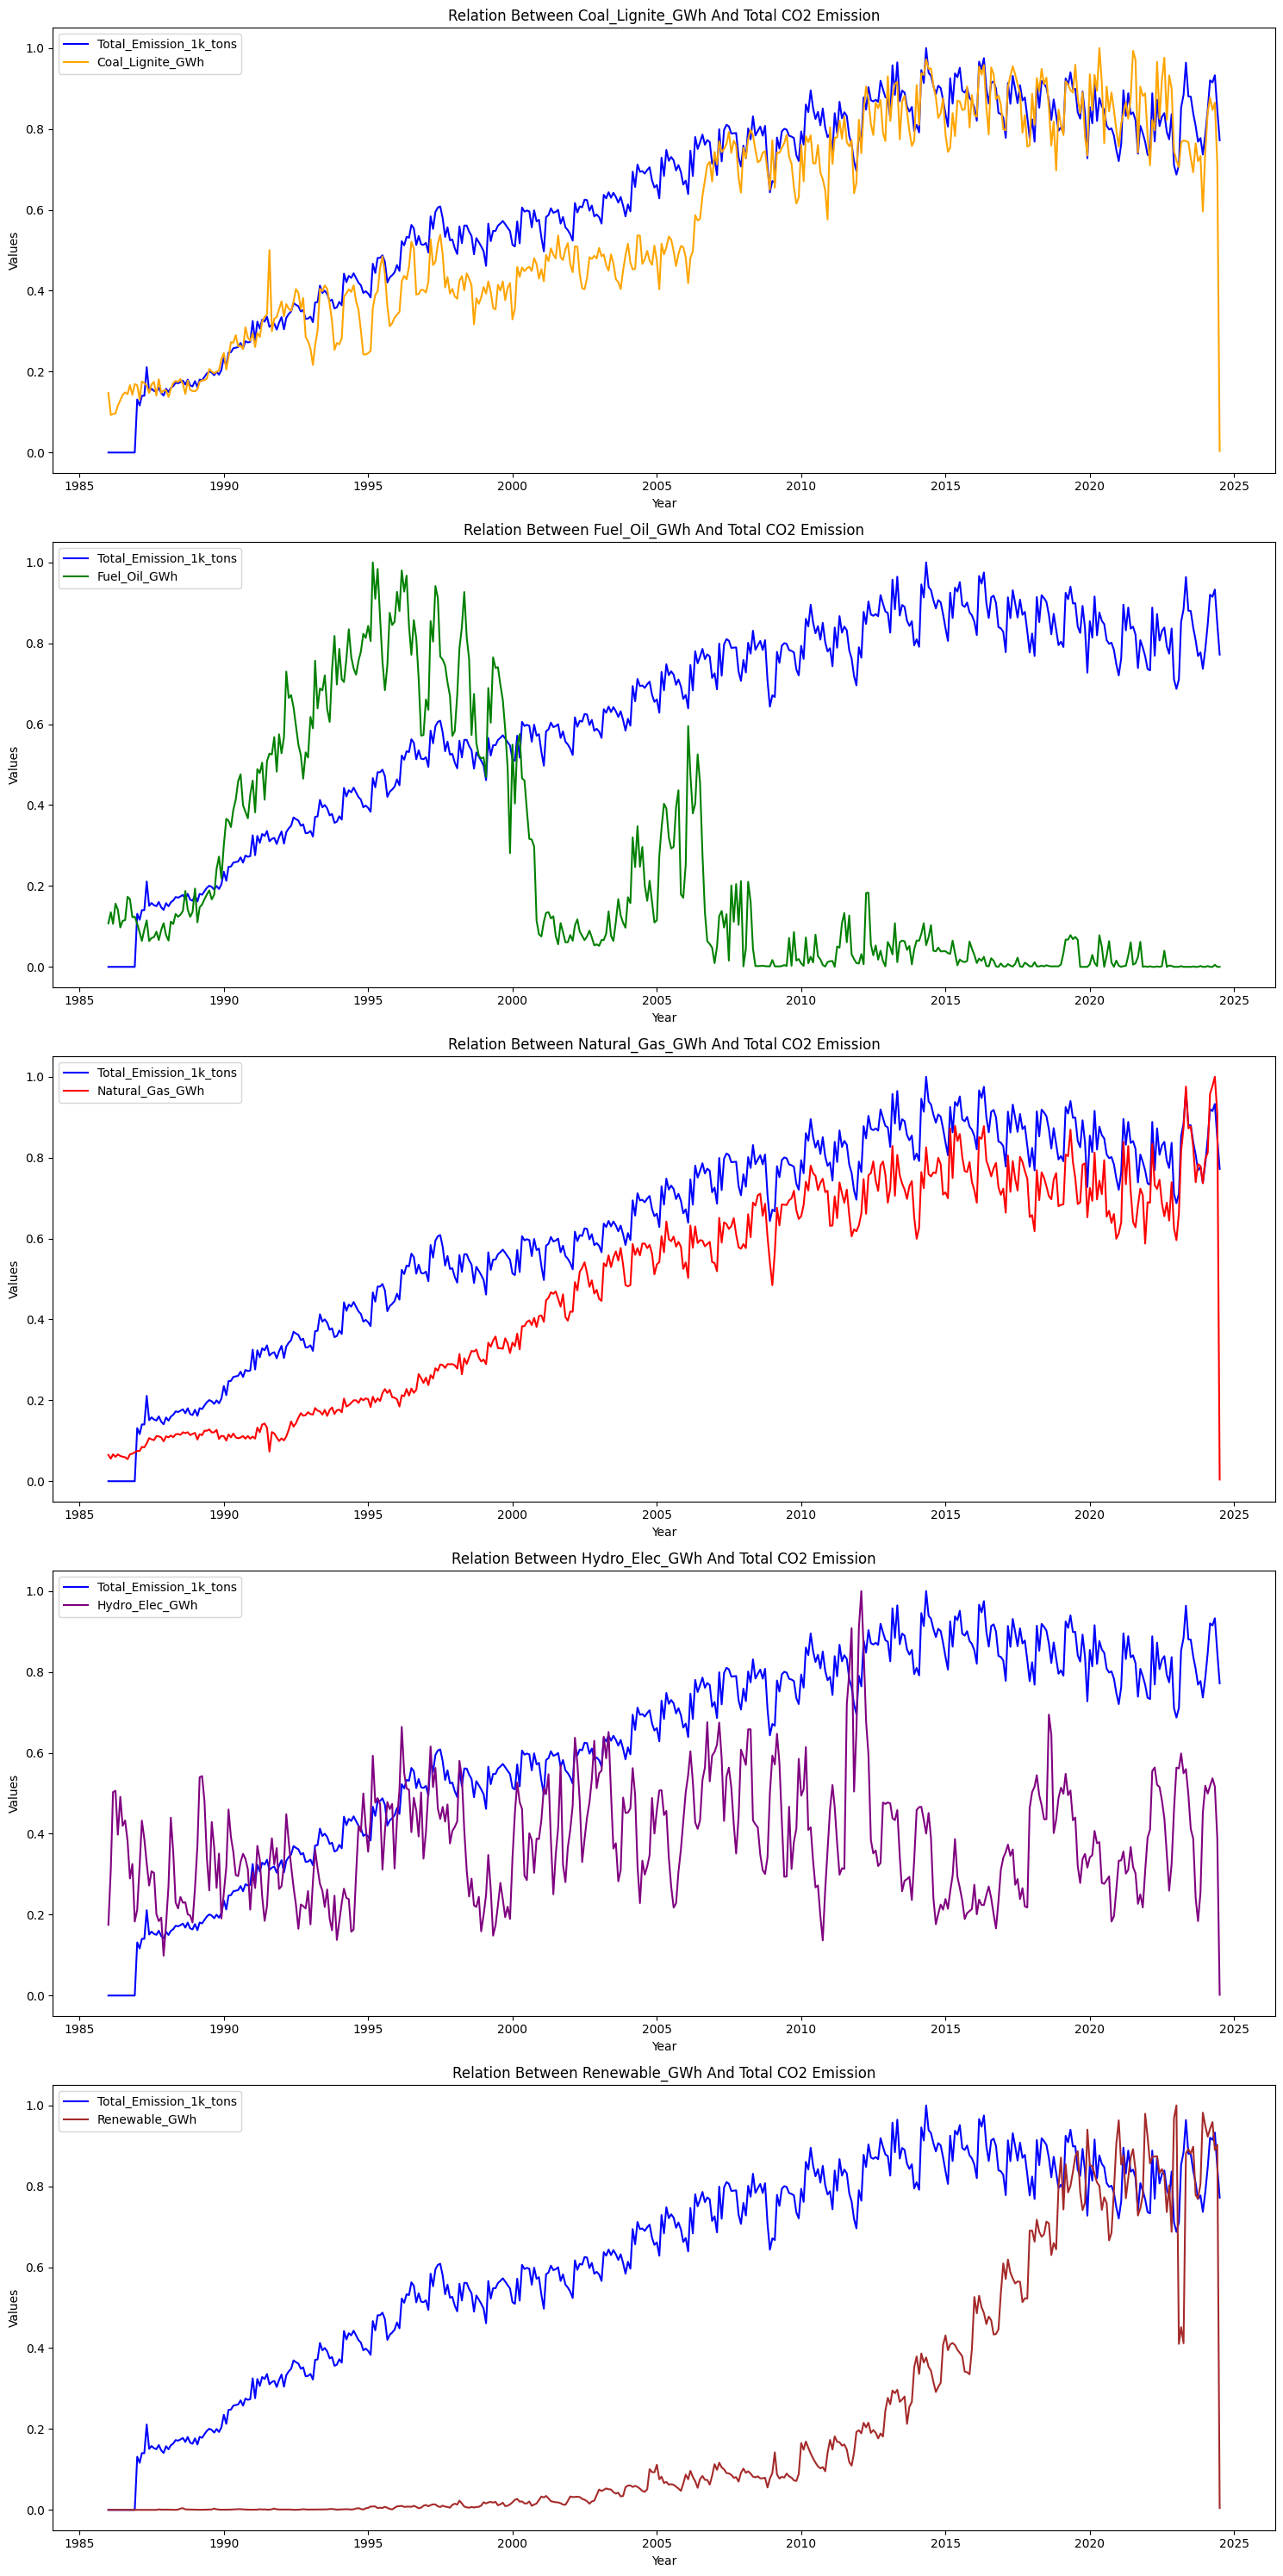

In [51]:
# Create the subplots (5 row, 1 columns in this case)
fig, axes = plt.subplots(5, 1, figsize=(15, 30))

# Plot 1: Relation Between Coal_Lignite_GWh And Total CO2 Emission
sns.lineplot(ax=axes[0], data=df_scale, x=df_scale.index, y='Total_Emission_1k_tons', label='Total_Emission_1k_tons', color='blue')
sns.lineplot(ax=axes[0], data=df_scale, x=df_scale.index, y='Coal_Lignite_GWh', label='Coal_Lignite_GWh', color='orange')
axes[0].set_title('Relation Between Coal_Lignite_GWh And Total CO2 Emission')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Values')

# Plot 2: Relation Between Fuel_Oil_GWh And Total CO2 Emission
sns.lineplot(ax=axes[1], data=df_scale, x=df_scale.index, y='Total_Emission_1k_tons', label='Total_Emission_1k_tons', color='blue')
sns.lineplot(ax=axes[1], data=df_scale, x=df_scale.index, y='Fuel_Oil_GWh', label='Fuel_Oil_GWh', color='green')
axes[1].set_title('Relation Between Fuel_Oil_GWh And Total CO2 Emission')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Values')

# Plot 3: Relation Between Natural_Gas_GWh And Total CO2 Emission
sns.lineplot(ax=axes[2], data=df_scale, x=df_scale.index, y='Total_Emission_1k_tons', label='Total_Emission_1k_tons', color='blue')
sns.lineplot(ax=axes[2], data=df_scale, x=df_scale.index, y='Natural_Gas_GWh', label='Natural_Gas_GWh', color='red')
axes[2].set_title('Relation Between Natural_Gas_GWh And Total CO2 Emission')
axes[2].set_xlabel('Year')
axes[2].set_ylabel('Values')

# Plot 4: Relation Between Hydro_Elec_GWh And Total CO2 Emission
sns.lineplot(ax=axes[3], data=df_scale, x=df_scale.index, y='Total_Emission_1k_tons', label='Total_Emission_1k_tons', color='blue')
sns.lineplot(ax=axes[3], data=df_scale, x=df_scale.index, y='Hydro_Elec_GWh', label='Hydro_Elec_GWh', color='purple')
axes[3].set_title('Relation Between Hydro_Elec_GWh And Total CO2 Emission')
axes[3].set_xlabel('Year')
axes[3].set_ylabel('Values')

# Plot 5: Relation Between Renewable_GWh And Total CO2 Emission
sns.lineplot(ax=axes[4], data=df_scale, x=df_scale.index, y='Total_Emission_1k_tons', label='Total_Emission_1k_tons', color='blue')
sns.lineplot(ax=axes[4], data=df_scale, x=df_scale.index, y='Renewable_GWh', label='Renewable_GWh', color='brown')
axes[4].set_title('Relation Between Renewable_GWh And Total CO2 Emission')
axes[4].set_xlabel('Year')
axes[4].set_ylabel('Values')

# Adjust the layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

### Model selection

In [72]:
features = ['Coal_Lignite_GWh', 'Fuel_Oil_GWh', 'Hydro_Elec_GWh', 'Natural_Gas_GWh', 'Renewable_GWh', 
            'Fuel_Oil_m.litres', 'Lignite_1k_ton', 'Natural_Gas_mmscf']
target = 'Total_Emission_1k_tons'

X = merged_df[features]
y = merged_df[target]

In [73]:
# Split the data into training and test sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [74]:
# Standardize the features (scaling)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [75]:
# Define the models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}

In [76]:
# Set the hyperparameters for GridSearchCV
param_grid = {
    'Linear Regression': {},
    'Random Forest': {
        'n_estimators': [100, 200], # Number of trees in the forest
        'max_depth': [10, 20, None], # Max depth of the trees
        'min_samples_split': [2, 5, 10], # Minimum number of samples required to split a node
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200], # Number of boosting stages
        'learning_rate': [0.01, 0.1], # Step size shrinking to prevent overfitting
        'max_depth': [3, 4, 5], # Max depth of individual trees
    }
}

In [77]:
# Function to perform GridSearchCV and cross-validation
def train_and_evaluate(model, param_grid, X_train, y_train):
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    cv_score = grid_search.best_score_
    
    print(f"Best Params for {model.__class__.__name__}: {best_params}")
    print(f"Best Cross-Validation Score (MSE): {-cv_score:.4f}")
    
    return best_model, best_params, -cv_score

In [78]:

# Evaluate all models with cross-validation and GridSearchCV
best_models = {}
for name, model in models.items():
    print(f"Training {name}...")
    best_model, best_params, best_cv_score = train_and_evaluate(model, param_grid[name], X_train, y_train)
    best_models[name] = {
        'model': best_model,
        'params': best_params,
        'cv_score': best_cv_score
    }
# Select the best model based on CV score (lowest MSE)
best_model_name = min(best_models, key=lambda x: best_models[x]['cv_score'])
best_model = best_models[best_model_name]['model']
best_params = best_models[best_model_name]['params']

print(f"Best Model: {best_model_name}")
print(f"Best Model Params: {best_params}")

# Make predictions on the test set with the best model
y_pred = best_model.predict(X_test)

# Evaluate the model on the test set (Mean Squared Error)
mse = mean_squared_error(y_test, y_pred)
print(f"Test Set Mean Squared Error (MSE): {mse:.4f}")

# Optional: Evaluate the model on R^2 (Coefficient of Determination)
r2 = best_model.score(X_test, y_test)
print(f"Test Set R^2: {r2:.4f}")

Training Linear Regression...
Best Params for LinearRegression: {}
Best Cross-Validation Score (MSE): 158310.9349
Training Random Forest...
Best Params for RandomForestRegressor: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 100}
Best Cross-Validation Score (MSE): 80888.1663
Training Gradient Boosting...
Best Params for GradientBoostingRegressor: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Best Cross-Validation Score (MSE): 61736.7052
Best Model: Gradient Boosting
Best Model Params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Test Set Mean Squared Error (MSE): 32412.9415
Test Set R^2: 0.9945


In [69]:
y_pred

array([6618.54853958, 1725.74995712, 1681.74328341, 6460.52454503,
       4844.9183391 , 5412.02872004, 6642.63616548, 5916.27664676,
       8087.6042214 , 3121.36760359, 7184.9246689 , 8524.58647004,
       3061.70212653, 8446.24556305, 7189.72531823, 7354.50845897,
       2900.3672946 , 3440.13814253, 4701.02075471,  -11.44386899,
       8480.55450801, 3123.69535858, 8389.60593208, 8280.21568348,
       6926.17999986, 7772.12084414, 5350.61749182, 4860.46192569,
       1586.3796118 ,  116.71198054, 7147.84508312, 8080.24242228,
       2893.34500989, 6801.35504336, 6766.59605338, 7791.15729702,
       2381.15894825, 3782.79068252, 8657.56846204, 3281.25125883,
       7812.7281756 , 7830.11121068, 5794.2229514 , 5237.32285777,
       5414.24033812, 2968.91116463, 4833.76046197, 3158.30583565,
       5118.18269116, 4673.92035721, 8504.30060107, 3053.46602054,
       7370.81235899, 5514.23267897, 4663.06661892, 6070.81581972,
       8194.19033017, 1714.6264283 , 7207.23457035, 7919.49334

### Testing

In [79]:

from sklearn.metrics import mean_squared_error, r2_score
y_pred = best_model.predict(X_test)
y_test = y_test
mse = mean_squared_error(y_test, y_pred) 
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error (MSE):{mse}')
print(f'Root Mean Squared Error (RMSE):{rmse}')
print(f'R^2:{r2}')

Mean Squared Error (MSE):32412.94151133793
Root Mean Squared Error (RMSE):180.03594505358626
R^2:0.9944647120069644


### Analysis

In [81]:
best_model.feature_importances_

array([0.0224244 , 0.0017228 , 0.00124148, 0.78125312, 0.00206014,
       0.0049523 , 0.01305004, 0.17329573])

<BarContainer object of 8 artists>

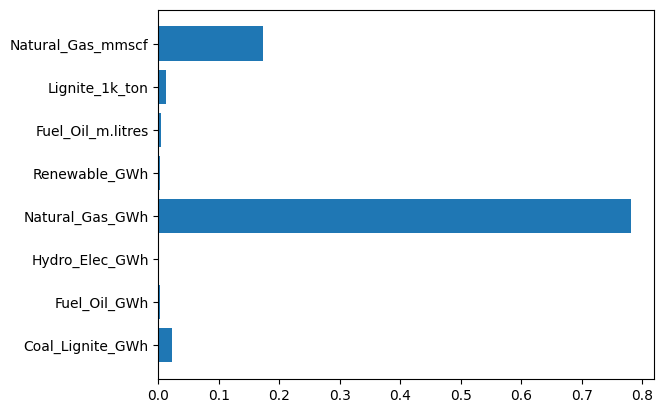

In [82]:
plt.barh(X.columns, best_model.feature_importances_)

<Axes: xlabel='Total_Emission_1k_tons'>

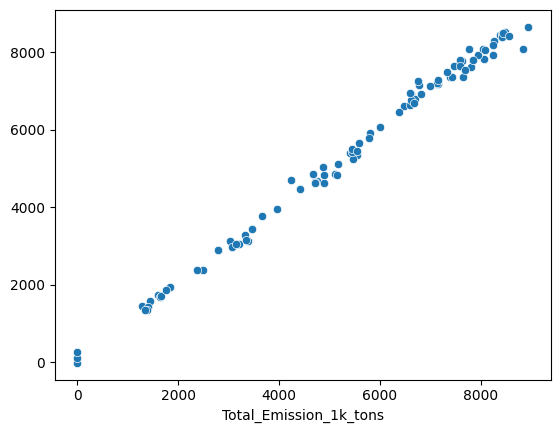

In [83]:
sns.scatterplot(x = y_test, y = y_pred)

<Axes: xlabel='Total_Emission_1k_tons'>

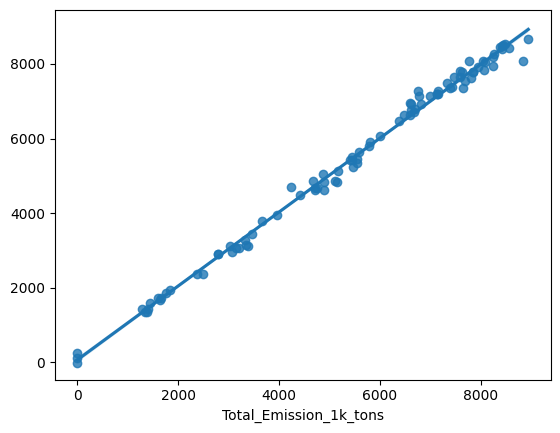

In [84]:
sns.regplot(y = y_pred, x = y_test)

### Inference

In [85]:
import pickle

filename = 'CO2Predicting'
pickle.dump(best_model, open(filename, 'wb'))

In [86]:
loaded_model = pickle.load(open(filename, 'rb'))

In [87]:
print(loaded_model)

GradientBoostingRegressor(max_depth=5, n_estimators=200, random_state=42)


In [90]:
sample = merged_df[['Coal_Lignite_GWh', 'Fuel_Oil_GWh', 'Hydro_Elec_GWh', 'Natural_Gas_GWh', 'Renewable_GWh', 
            'Fuel_Oil_m.litres', 'Lignite_1k_ton', 'Natural_Gas_mmscf']].iloc[20]

In [91]:
sample

Coal_Lignite_GWh       491.400
Fuel_Oil_GWh           185.670
Hydro_Elec_GWh         252.050
Natural_Gas_GWh       1510.700
Renewable_GWh            0.000
Fuel_Oil_m.litres       49.324
Lignite_1k_ton         419.637
Natural_Gas_mmscf    13840.210
Name: 1987-09-01 00:00:00, dtype: float64